In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
import yfinance as yf

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## 최대 예상 손실(Value at Risk)

최대 예상 손실은 주어진 시간과 사전 정의된 신뢰구간 동안 회사가 가지고 있는 자산의 최대 예상 손실을 측정하는데 사용되는 시장리스크 관리 지표이다. 예를 들어 투자의 일 VaR이 95% 신뢰구간에서 100만 달러라는 것은 해당 포트폴리오를 소유한 투자자가 하루에 100만 달러 이상의 손해를 입을 가능성이 5%라는 의미이다. 

VaR의 구성 요소에는 신뢰구간, 기간, 포트폴리오 가치, 그리고 변동성으로 이루어져 있다.

다음은 VaR 분석에서 주목해야 할 몇 가지 중요한 사항을 요약한 것이다.

1. VaR은 손실 가능성에 대한 추정이 필요하다.

2. VaR은 잠재적 손실에 대한 예측이다. 실현 손실에 대한 예측이 아니다.

3. VaR은 신뢰구간, 변동성, 기간이라는 3 가지 핵심 요소를 가지고 있다.


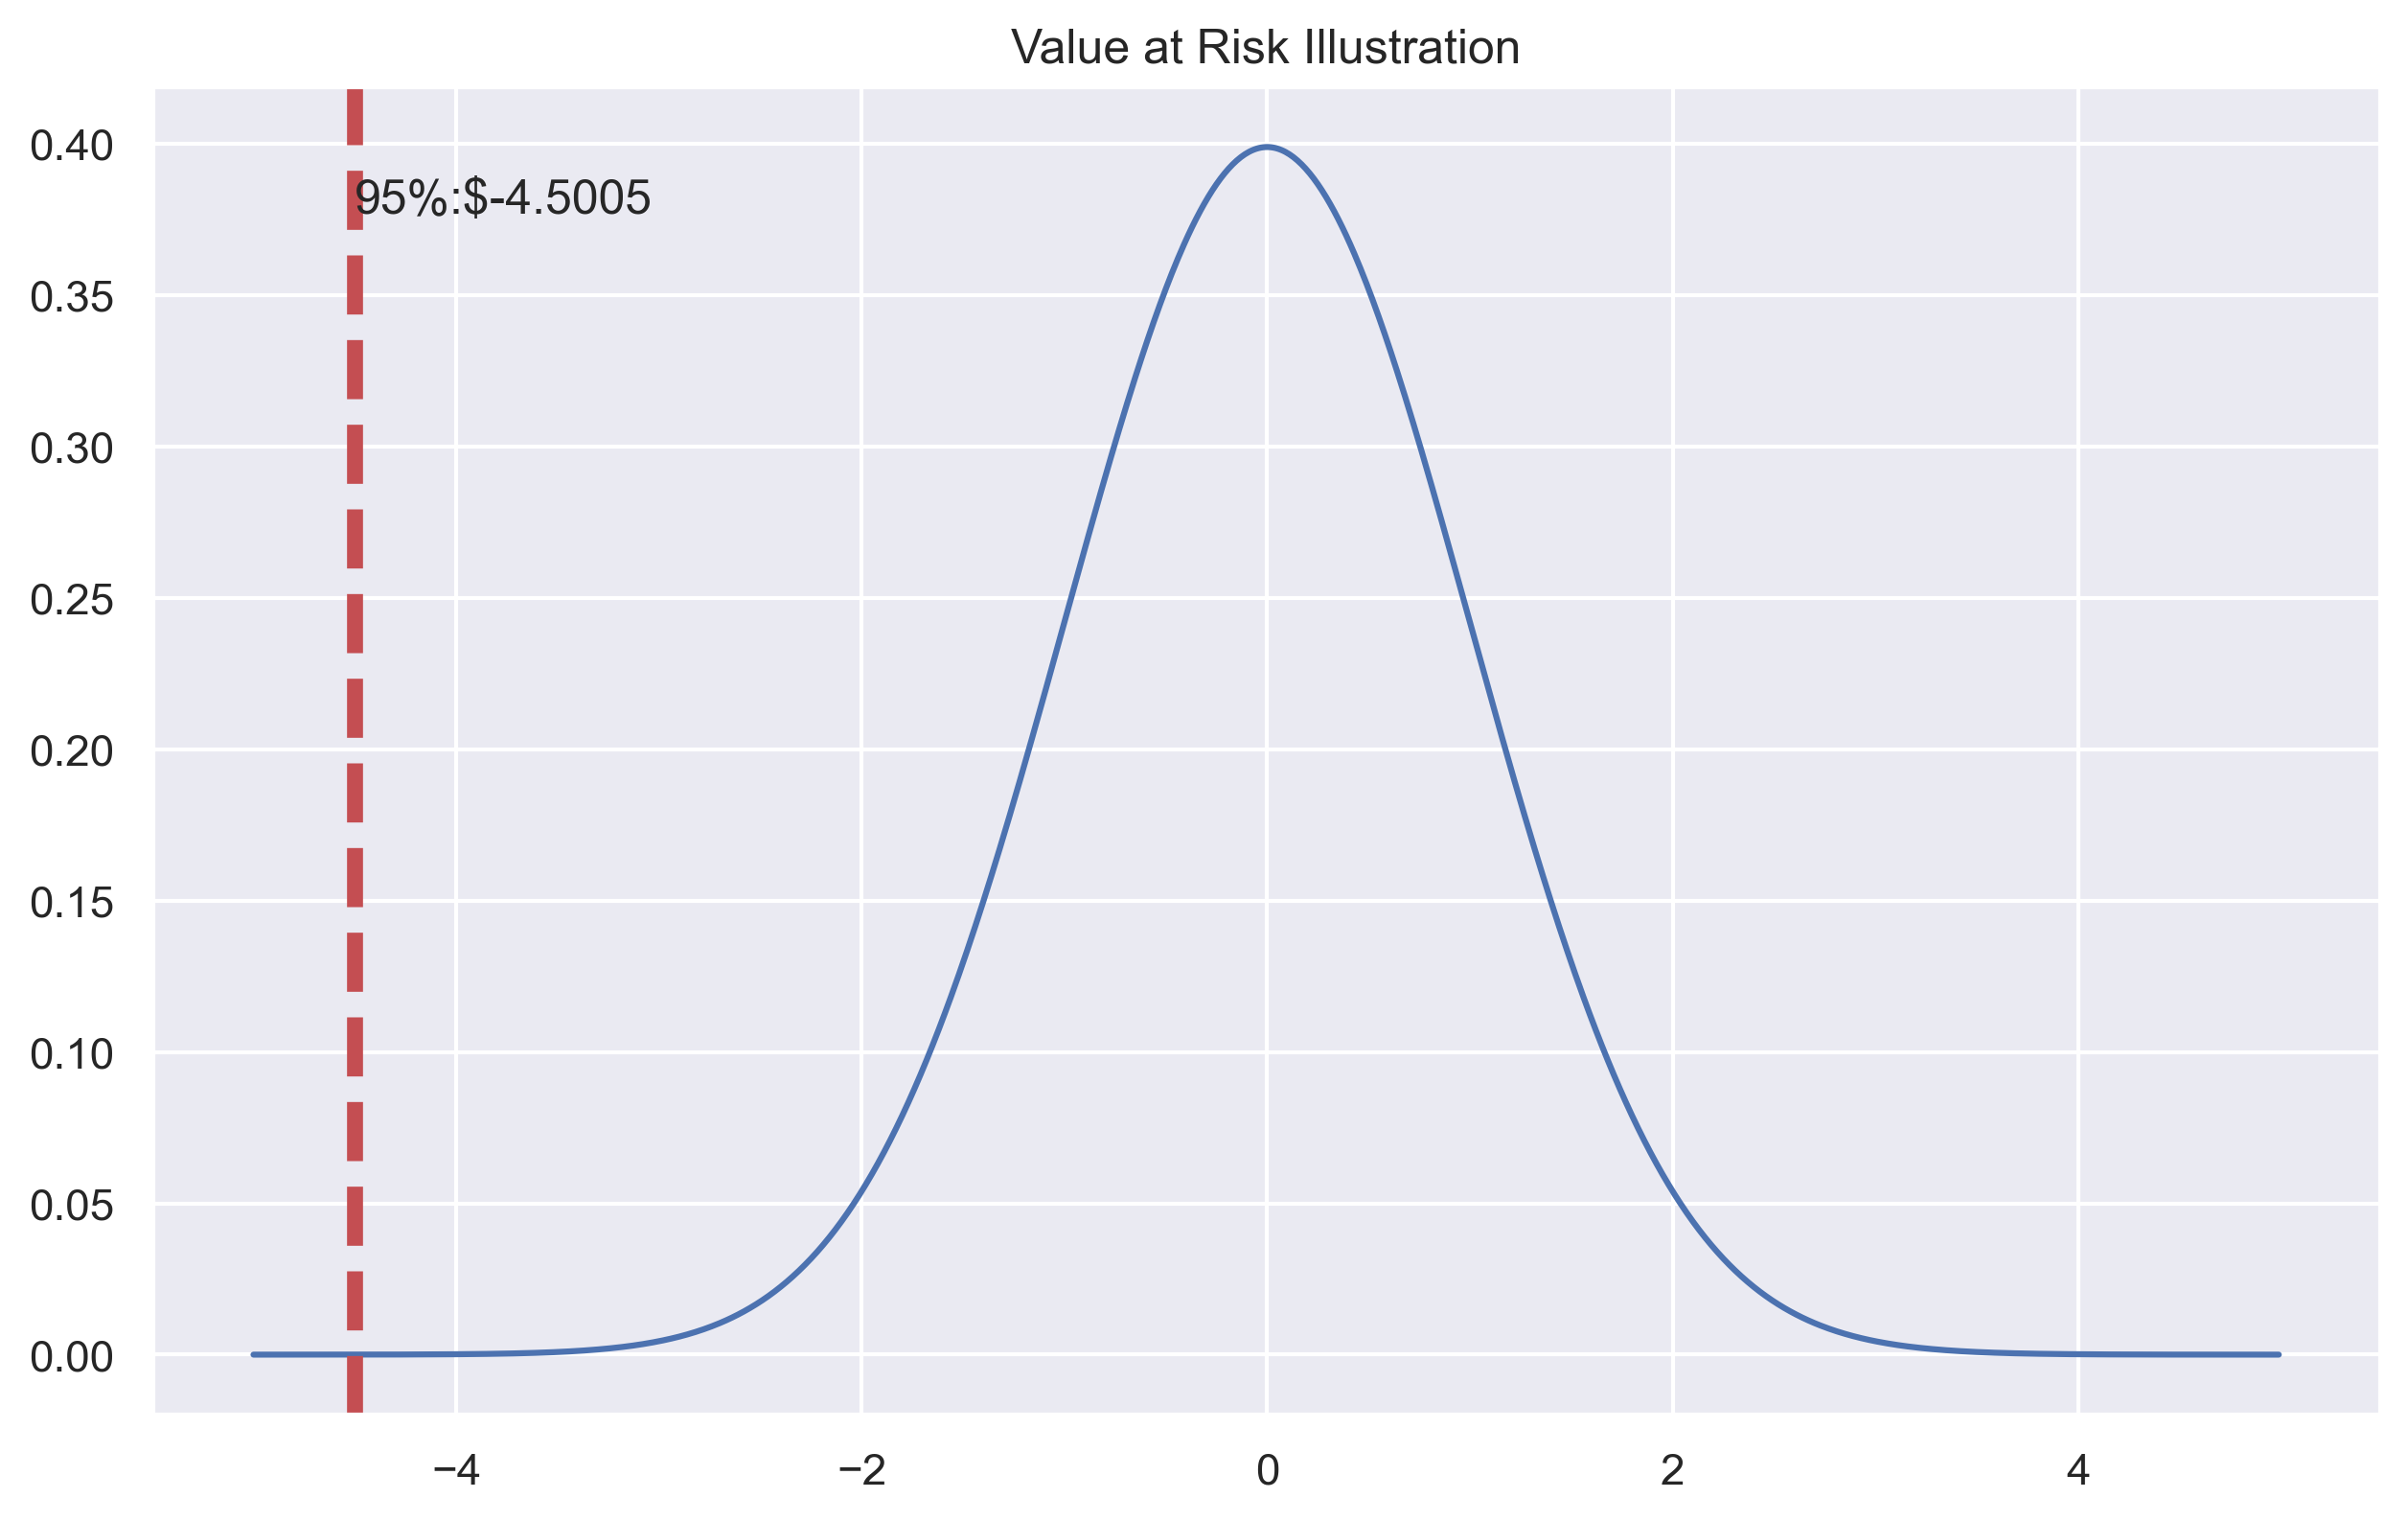

In [2]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

VaR에는 일반적으로 3가지 접근법이 존재한다. 

1. 분산 - 공분산 VaR
2. 과거 시뮬레이션 VaR
3. 몬테 카를로 VaR

## Variance-Covariance Method

분산 - 공분산 기법은 다른 말로 델타-노말 기법이라고도 한다. 이는 관측값의 분포(ex : 주식 수익률의 분포, 이자율의 분포, 기초자산의 분포 등)가 정규분포를 따른다는 것과 기초자산과 포트폴리오 가치의 관계가 선형임을 가정하고 VaR을 계산하는 것을 의미한다. 따라서 이를 모수적 방법이라고 부르기도 한다.

분산 - 공분산 기법에서 가장 중요한 것은 포트폴리오의 공분산 행렬을 구하는 것이다. 일반적으로 과거 데이터를 사용해 공분산 행렬, 평균 벡터 등을 계산한다.

다음은 분산 - 공분산 기법을 사용해 VaR을 계산하는 과정이다.

In [3]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(yf.download(symbol, '2020-01-01', '2020-12-31')['Close'])
stocks = pd.DataFrame(stock3).T
stocks.columns = symbols

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
stocks.head()

,IBM,MSFT,INTC
Date,,,
2020-01-02,129.464630,160.619995,60.840000
2020-01-03,128.432129,158.619995,60.099998
2020-01-06,128.202682,159.029999,59.930000
2020-01-07,128.288712,157.580002,58.930000
2020-01-08,129.359467,160.089996,58.970001


In [5]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

,IBM,MSFT,INTC
Date,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
2020-01-09,0.010513,0.012416,0.005580
...,...,...,...
2020-12-23,0.002343,-0.013125,0.008626
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000


In [6]:
stocks_returns_mean = stocks_returns.mean()
weights  = [1/3]*3
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))
stock_cov=np.diag(cov_var)   # 각 종목 분산 데이터

In [7]:
port_return_mean = np.dot(stocks_returns, weights).mean()

In [8]:
initial_investment = 1e6   # 원금 100만 달러에 대해 동일비중 포트폴리오와 각 종목에만 투자하는 세가지 포트폴리오 비교
conf_level = 0.95

In [9]:
def VaR_parametric(initial_investment, conf_level, cov):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = -initial_investment * (alpha)[j]
        print("Parametric VaR result for {} is {} ".format(i, VaR_param))
    VaR_param = -initial_investment * (alpha)
    print('--' * 25)
    return VaR_param

In [10]:
VaR_param = VaR_parametric(initial_investment, conf_level, stock_cov)

alpha = norm.ppf(1 - conf_level, port_return_mean, port_std)
VaR_param_port = (initial_investment - initial_investment * (1 + alpha))
print("Parametric VaR result for {} is {} ".format("equal_weight_portfolio", VaR_param_port))

Parametric VaR result for IBM is 42971.68071825573 
Parametric VaR result for MSFT is 41347.956059765645 
Parametric VaR result for INTC is 43514.23432115943 
--------------------------------------------------
Parametric VaR result for equal_weight_portfolio is 42611.290366393514 


데이터가 iid로 산출되었다고 가정할 때, 일간변동성 $\sigma$가 주어졌다면 t기간의 변동성 $\sigma_t$는 $\sigma_t=\sigma \sqrt {t}$로 계산할 수 있다. 즉 VaR은 보유 기간이 길어질 수록 더욱 커지는 성질을 가지고 있다. 다음 그림는 보유기간에 따른 VaR의 변화를 보여준다.

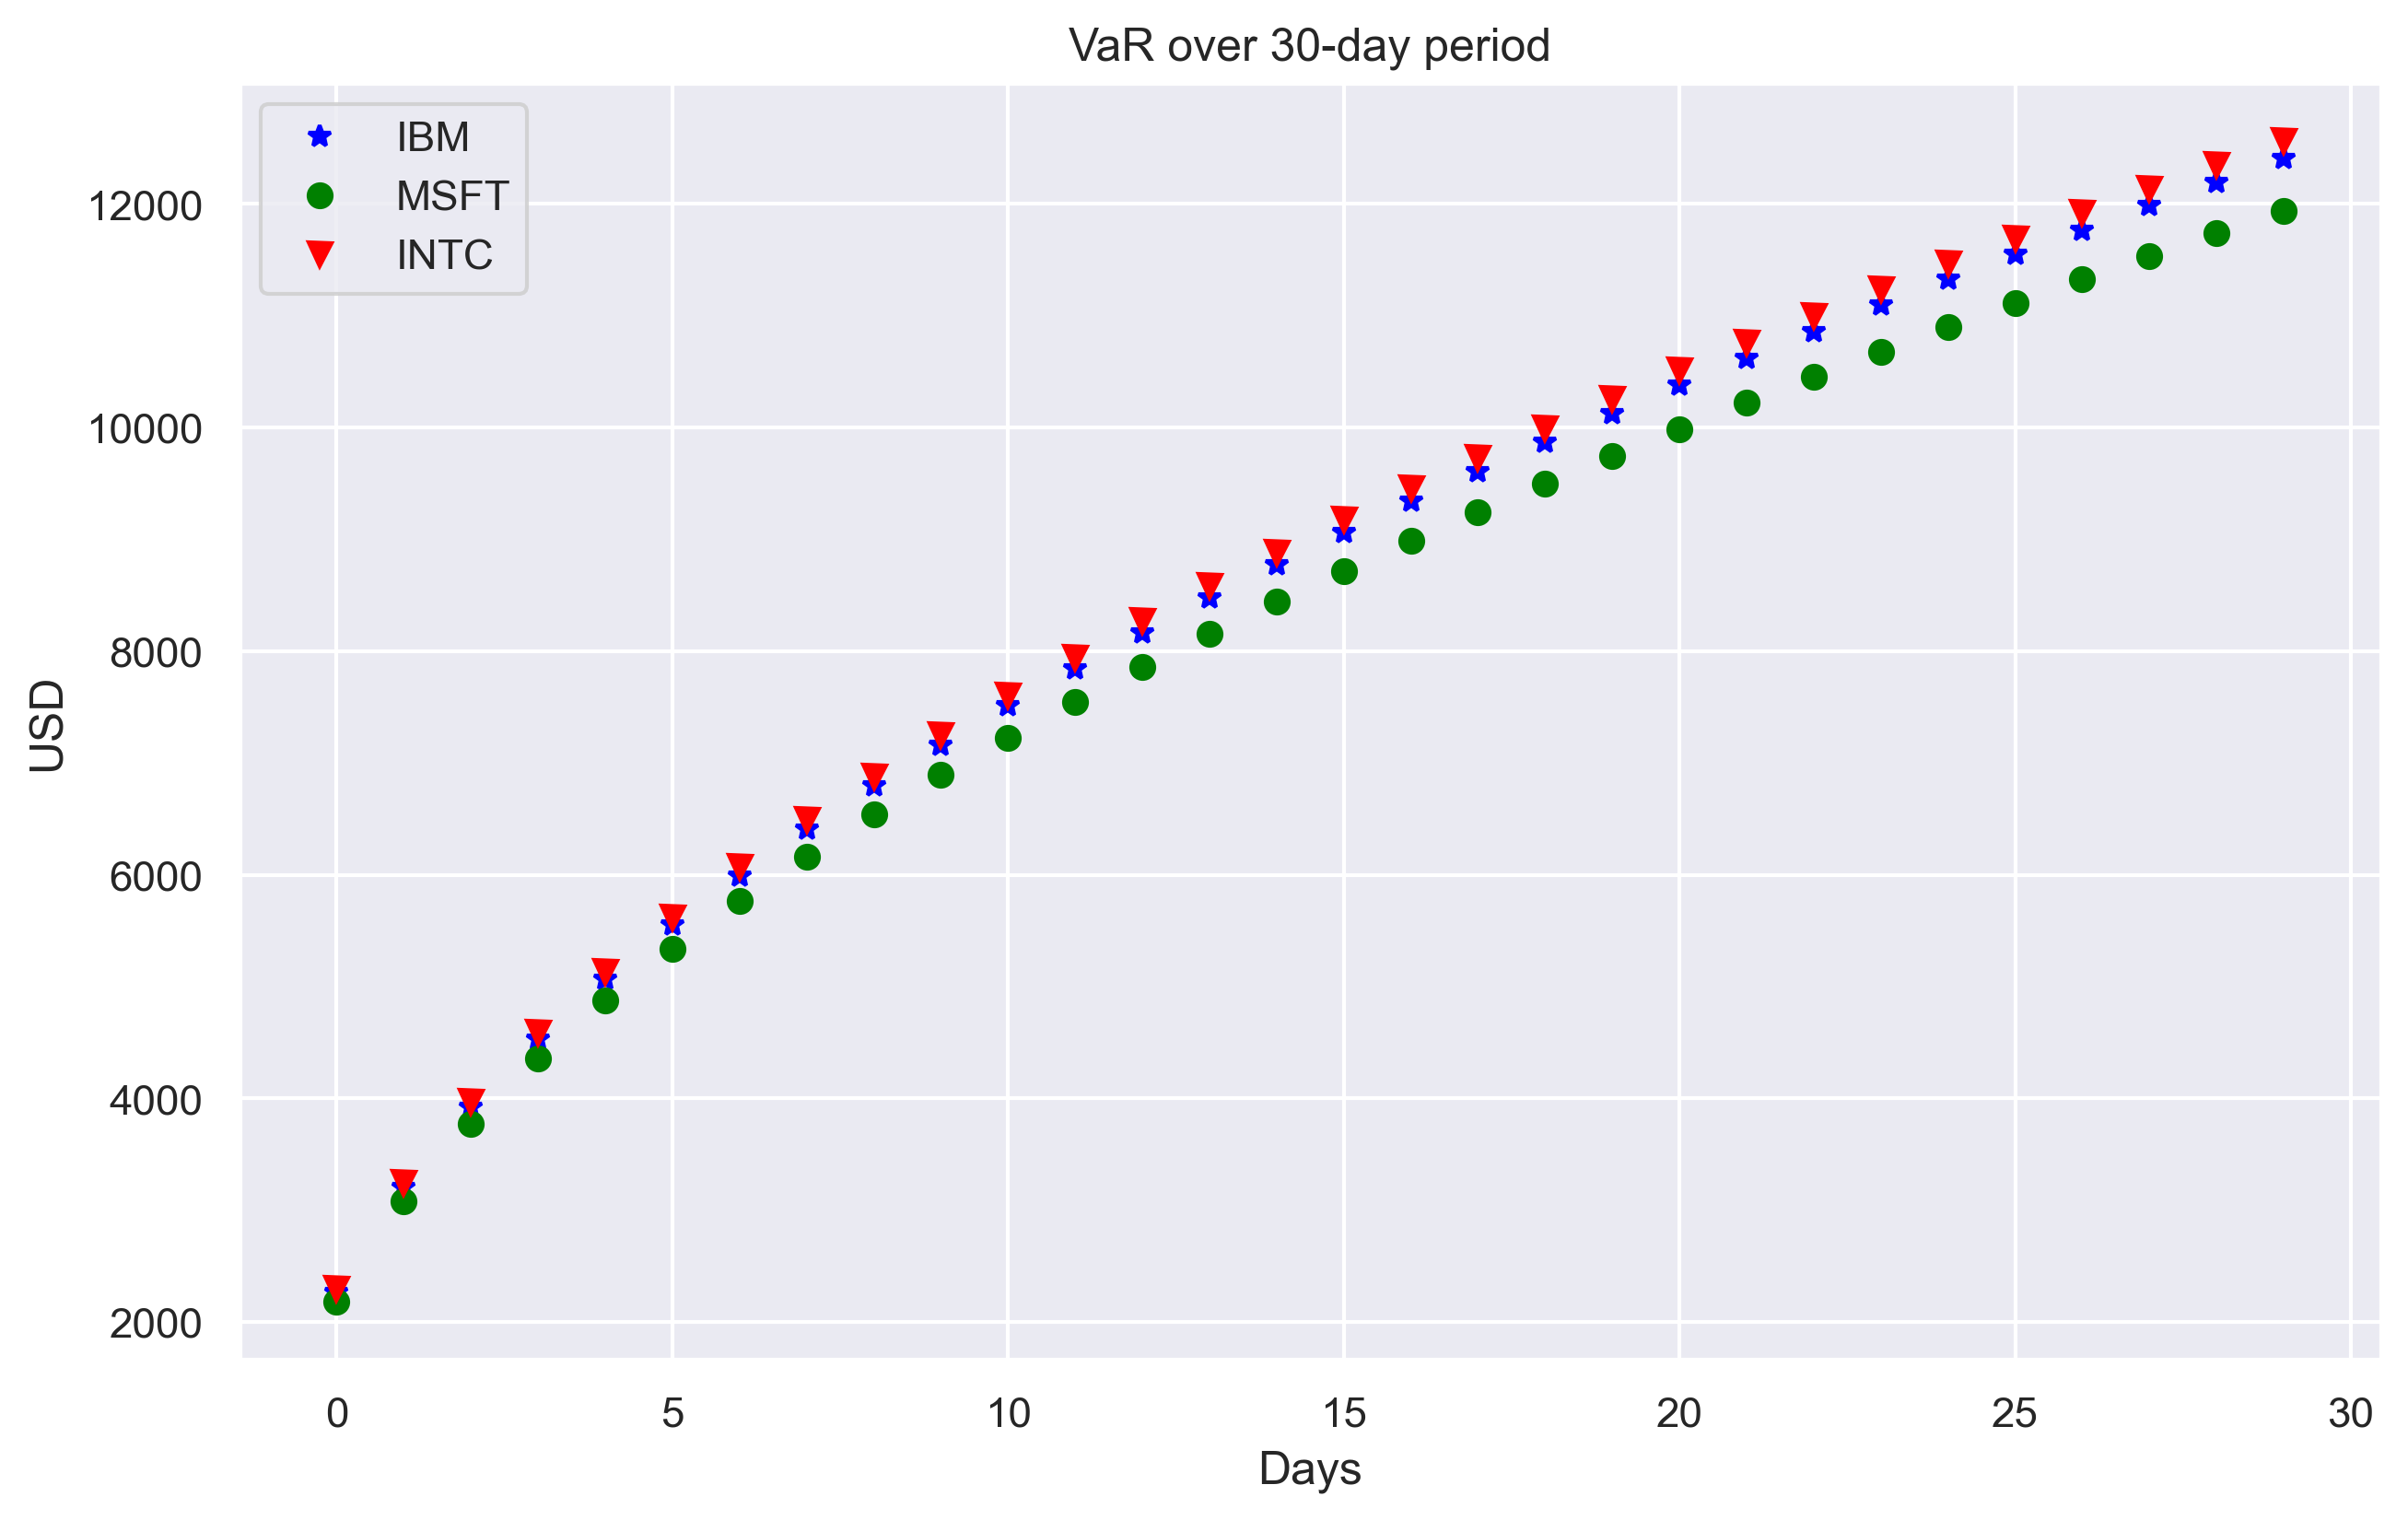

In [11]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i/360))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

분산 - 공분산 기법의 장점은 다음과 같다.

1. 계산이 용이하다.
2. 많은 수의 샘플이 필요하지 않다.


분산 - 공분산 기법의 단점은 다음과 같다.

1. 일반적으로 금융 데이터는 정규분포를 따르지 않는다.
2. 비선형 구조에서는 오차가 발생한다.
3. 공분산 행렬의 계산이 필요하며, 이는 높은 시간복잡도를 요구한다.

## Historical Simulation VaR

역사적 시뮬레이션 방법은 분포를 가정하지 않는다는 점에서 비모수적 방법이라고도 불린다. 역사적 시뮬레이션은 과거 관측치에서 해당 신뢰구간에 맞는 백분위수를 찾은 뒤, 이 백분위수에 초기 투자를 곱하는 방법으로 VaR을 계산한다.

역사적 시뮬레이션 방법을 정리하면 다음과 같다.

1. 포트폴리오의 과거 수익률 계산
2. 신뢰구간을 기반으로 해당 수익 백분위수 계산
3. 이 백분위수에 초기 투자를 곱해 VaR 계산

다음은 역사적 시뮬레이션 방법을 구현한 코드이다.


In [12]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                             5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
             .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                         (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
             .format(i, VaR_historical))
        print('--' * 35)

In [13]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of IBM's return is -0.0372
Historical VaR result for IBM is 37201.07 
----------------------------------------------------------------------
Based on historical values 95% of MSFT's return is -0.0426
Historical VaR result for MSFT is 42622.24 
----------------------------------------------------------------------
Based on historical values 95% of INTC's return is -0.0425
Historical VaR result for INTC is 42509.24 
----------------------------------------------------------------------


역사적 시뮬레이션은 금융 데이터의 구조적 변화가 없다고 암묵적으로 가정한다는 한계가 존재한다. 즉, 시뮬레이션 결과가 과거 데이터에 과적합될 가능성이 존재한다.

역사적 시뮬레이션의 장점은 다음과 같다.

1. 분포에 대한 가정이 없다.
2. 비선형 구조에서도 잘 작동한다.
3. 계산이 간편하다.


역사적 시뮬레이션의 단점은 다음과 같다.

1. 많은 샘플이 필요하다.
2. 시뮬레이션 결과가 과거 데이터에 과적합될 가능성이 존재한다.

## Monte Carlo VaR

몬테 카를로 VaR 기법에 대해 알아보기 전에, 몬테 카를로 시뮬레이션에 대해 우선 알아보자.


몬테카를로 시뮬레이션이란, 통계학에서 사용되는 큰 수의 법칙을 금융에 이용한 것이다. 파생상품뿐만이 아닌 모든 자산의 가격은 다음 식을 만족합니다.

$$ P_t = e^{-r(T-t)}E(CF_T) $$

이때 $P_t$는 자산의 현재 가격, $CF_T$는 만기 시점에서의 현금흐름이다. 또 $t$는 현재 시점을, $T$는 만기 시점을 나타낸다. 즉, 만기 시점에서의 현금흐름의 기댓값을 현재가치화한 것이 자산의 가격이다.
하지만 현금흐름의 기댓값을 수학적으로 구하기 어렵다는 것이 가격결정의 가장 큰 문제점이다. 몬테카를로 시뮬레이션은 이 문제를 큰 수의 법칙을 이용해 해결한다.
큰 수의 법칙은 다음과 같다.

If $N$ is big,
$$ E(X) \approx {{(X_1 + X_2 + X_3 + ...+ X_N)}\over N} $$

몬테카를로 시뮬레이션은 큰 수의 법칙을 이용해 현재 알고 있는 주가의 분포를 활용해 가능한 주가 시나리오를 최대한 많이 제작하여, 만기 시점에서의 현금흐름의 평균을 구해 현재가치화하는 방법을 사용한다.

가장 기본적으로 사용되는 주가 분포 시나리오는 기하브라운 운동(GBM)이다. GBM을 따르는 주가는 다음 확률과정을 따른다.

$$ {dS \over S}  = rdt + \sigma dW $$

이때 $r$은 무위험이자율, $\sigma$는 주가의 $dt$시간 동안의 변동성, $dW$는 표준정규분포를 따르는 확률변수이다.

즉 이 식에서 시나리오를 제작해야 하는 불확실한 과정, 즉 확률과정은 $dW$ 뿐이므로, $dW$의 시나리오를 제작하여 위 식에 대입하면 주가의 시나리오를 제작할 수 있다.

하지만 포트폴리오 자산 간에는 상관관계가 존재하므로, 상관관계를 가지는 여러 개의 자산을 분석할 때에는 단순히 두 개의 기하브라운 식을 구축하는 것으로는 충분하지 않다. 이를 위해서는 촐레스키 분해를 사용한다.

촐레스키 분해를 통해 상관계수 행렬은 다음과 같이 분해된다.
$$\Omega = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}	 = \begin{bmatrix} 1 & 0 \\ \rho &\sqrt{1-\rho^2}  \end{bmatrix}	\begin{bmatrix} 1 & \rho \\ 0 &\sqrt{1-\rho^2}  \end{bmatrix} = LL^T	$$

그리고 $L$을 곱한 난수행렬을 다음과 같이 정의하면 새로운 두 난수는 $\rho$의 상관계수를 가지는 난수가 된다.
$$\begin{bmatrix} Z_1 \ \\ Z_2 \end{bmatrix} = L \begin{bmatrix} W_1 \ \\ W_2 \end{bmatrix}$$ 

(단, $W_1, \ W_2$는 Wiener stochastic process)

이는 자산이 N개일때도 동일하게 적용이 가능하다.

몬테 카를로 시뮬레이션에서는 위의 방법을 사용해 주가의 시나리오를 제작하고, 시나리오를 바탕으로 주어진 신뢰구간에 해당하는 백분위수의 수익률을 찾아 VaR을 계산하는 방법을 사용한다. 역사적 시뮬레이션과 비슷한 과정을 거치나, 데이터가 시뮬레이션 데이터냐 과거 데이터냐에 차이가 존재한다.

다음 코드는 촐레츠키 분해를 사용해 몬테 카를로 시뮬레이션을 수행하고 해당 데이터를 바탕으로 VaR을 계산하는 과정이다.

In [14]:
import scipy

T = 1
days = 250
nsimulation = 300000
r=0.01
stock_sigma=np.sqrt(stock_cov)  # 각 종목의 일별 변동성

L=scipy.linalg.cholesky(np.corrcoef([stocks_returns.iloc[:, 0], stocks_returns.iloc[:, 1], stocks_returns.iloc[:, 2]]), lower=True)

Normal1 = np.random.normal(size=(T*days, nsimulation))
Normal2 = np.random.normal(size=(T*days, nsimulation))
Normal3 = np.random.normal(size=(T*days, nsimulation))

nor1 = Normal1.reshape(1,T*days*nsimulation)
nor2 = Normal2.reshape(1,T*days*nsimulation)
nor3 = Normal3.reshape(1,T*days*nsimulation)

dz=[]
for i in range(len(nor1)):
    dz.append(np.dot(L, np.array([nor1[i], nor2[i], nor3[i]])))

dz=np.array(dz[0])

cor1 = dz[0, :]
cor2 = dz[1, :]
cor3 = dz[2, :]

Normal1 = cor1.reshape(T*days,nsimulation)
Normal2 = cor2.reshape(T*days,nsimulation)
Normal3 = cor3.reshape(T*days,nsimulation)


dt = 1/250
logds1 = r*dt + Normal1 * stock_sigma[0]
logds2 = r*dt + Normal2 * stock_sigma[1]
logds3 = r*dt + Normal3 * stock_sigma[2]

path1 = np.zeros((T*days+1,nsimulation))
path2 = np.zeros((T*days+1,nsimulation))
path3= np.zeros((T*days+1,nsimulation))

path1[0] = 129.46463
path2[0] = 160.619995
path3[0] = 60.840000

for i in range(1,T*days+1):
    path1[i] = path1[i-1]*(1+logds1[i-1])  # 이미 일별 변동성을 계산했으므로 np.sqrt(dt)를 안곱해줘도 됨!
    path2[i] = path2[i-1]*(1+logds2[i-1])
    path3[i]= path3[i-1]*(1+logds3[i-1])

path1=pd.DataFrame(path1)
IBM_return=(np.log(path1)-np.log(path1.shift(1))).dropna()
path2=pd.DataFrame(path2)
MSFT_return=(np.log(path2)-np.log(path2.shift(1))).dropna()
path3=pd.DataFrame(path3)
INTC_return=(np.log(path3)-np.log(path3.shift(1))).dropna()


In [15]:
sim_return=pd.concat( [pd.Series(np.array(IBM_return).flatten()), pd.Series(np.array(MSFT_return).flatten()), pd.Series(np.array(INTC_return).flatten())], axis=1)
sim_return.columns=stocks.columns
sim_return

,IBM,MSFT,INTC
0,-0.015379,0.012673,0.032066
1,-0.018095,-0.015683,-0.009330
2,0.040375,0.038499,0.048700
3,0.006050,-0.039963,-0.017133
4,-0.013042,-0.003907,-0.027912
...,...,...,...
74999995,-0.061748,0.012675,-0.002048
74999996,-0.005182,0.003595,0.019544
74999997,-0.029439,-0.010495,-0.026492
74999998,0.018201,0.005579,0.012691


In [16]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_return.columns, range(len(sim_return.columns))):
        MC_percentile95.append(np.percentile(sim_return.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [17]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of IBM's return is -0.0436
Simulation VaR result for IBM is 43604.26 
----------------------------------------------------------------------
Based on simulation 95% of MSFT's return is -0.0468
Simulation VaR result for MSFT is 46776.47 
----------------------------------------------------------------------
Based on simulation 95% of INTC's return is -0.0576
Simulation VaR result for INTC is 57636.88 
----------------------------------------------------------------------


## The Marcenko-Pastur Theory

공분산 행렬은 금융 어디에서나 존재한다. 경험적 공분산 행렬은 랜덤 벡터를 구성하는 랜덤 변수 사이의 선형 결합을 추정하고자 랜덤 벡터의 일련의 관측값에 대해 계산된다. 이러한 관측값의 유한성과 비결정론적 특성을 고려할 때 공분산 행렬의 추정값에는 일정량의 잡음이 포함되어 있다

금융시장 분석에 있어서 factor들은 이러한 불안정한 공분산으로부터 추정되었기 떄문에 추정된 공분산은 필연적으로 불량 조건 하에 있게 된다. 이 잡음을 처리하지 않는 한 공분산 행렬로 수행하는 계산에 영향을 미칠 수 있으며, 때로는 분석을 무용지물로 만들 수도 있다. 따라서 공분산 행렬에서의 잡음을 줄이고, 경험적 공분산 행렬에 포함된 신호를 개선하도록 하는 방법이 필요하다.

관측값을 생성하는 기본 프로세스의 평균 0과 분산 $\sigma^2$인 독립적이고 동일하게 분포된 랜덤 관측값 X의 행렬을 고려하자. 행렬 $C = T^{-1}X^\prime X$는 Marcenko-Pastur Probability Density Function으로 점근적으로 수렴하는 고유값을 가진다

$$f(\lambda) = \begin{cases}
\frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2 \pi \lambda \sigma^2}, & \mathbb{     if }\lambda \in [\lambda_-, \lambda_+] \\
0, & \mathbb{     if }\lambda \notin [\lambda_-, \lambda_+]
\end{cases}$$

여기서 최대 기대 고유값은 $\lambda_+ = \sigma^2(1 + \sqrt{N/T})^2$이고, 최소 기대 고유값은 $\lambda_- = \sigma^2 (1-\sqrt{N/T})^2$이다. $\sigma^2 = 1$일 때 $C$는 $X$와 연관된 상관 행렬이다. 

아래와 같이 Marcenko-Pastur 분포가 Random Matrix의 고유값을 얼마나 근접하게 설명하는지 보여 준다

In [18]:
def mp_pdf(sigma2, q, obs): # q=T/N, obs는 일종의 정밀도
    lambda_plus = sigma2 * (1 + q ** 0.5) ** 2
    lambda_minus = sigma2 * (1 - q ** 0.5) ** 2
    l = np.linspace(lambda_minus, lambda_plus, obs)
    pdf_mp = 1 / (2 * np.pi * sigma2 * q * l) \
             * np.sqrt((lambda_plus  - l) 
             *  (l - lambda_minus))
    pdf_mp = pd.Series(pdf_mp, index=l)
    return pdf_mp

In [19]:
from sklearn.neighbors import KernelDensity

def kde_fit(bandwidth,obs,x=None):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    if len(obs.shape) == 1:
        kde_fit=kde.fit(np.array(obs).reshape(-1, 1))
    if x is None:
        x=np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logprob = kde_fit.score_samples(x)
    pdf_kde = pd.Series(np.exp(logprob), index=x.flatten())
    return pdf_kde

In [20]:
corr_mat = np.random.normal(size=(10000, 1000))
corr_coef = np.corrcoef(corr_mat, rowvar=0)
sigma2 = 1
obs = corr_mat.shape[0]
q = corr_mat.shape[0] / corr_mat.shape[1]

def plotting(corr_coef, q):
    ev, _ = np.linalg.eigh(corr_coef)
    idx = ev.argsort()[::-1]
    eigen_val = np.diagflat(ev[idx])
    pdf_mp = mp_pdf(1., q=corr_mat.shape[1] / corr_mat.shape[0],
                    obs=1000)
    kde_pdf = kde_fit(0.01, np.diag(eigen_val))
    ax = pdf_mp.plot(title="Marchenko-Pastur Theorem",
                     label="M-P", style='r--')
    kde_pdf.plot(label="Empirical Density", style='o-', alpha=0.3)
    ax.set(xlabel="Eigenvalue", ylabel="Frequency")
    ax.legend(loc="upper right")
    plt.show()
    return plt

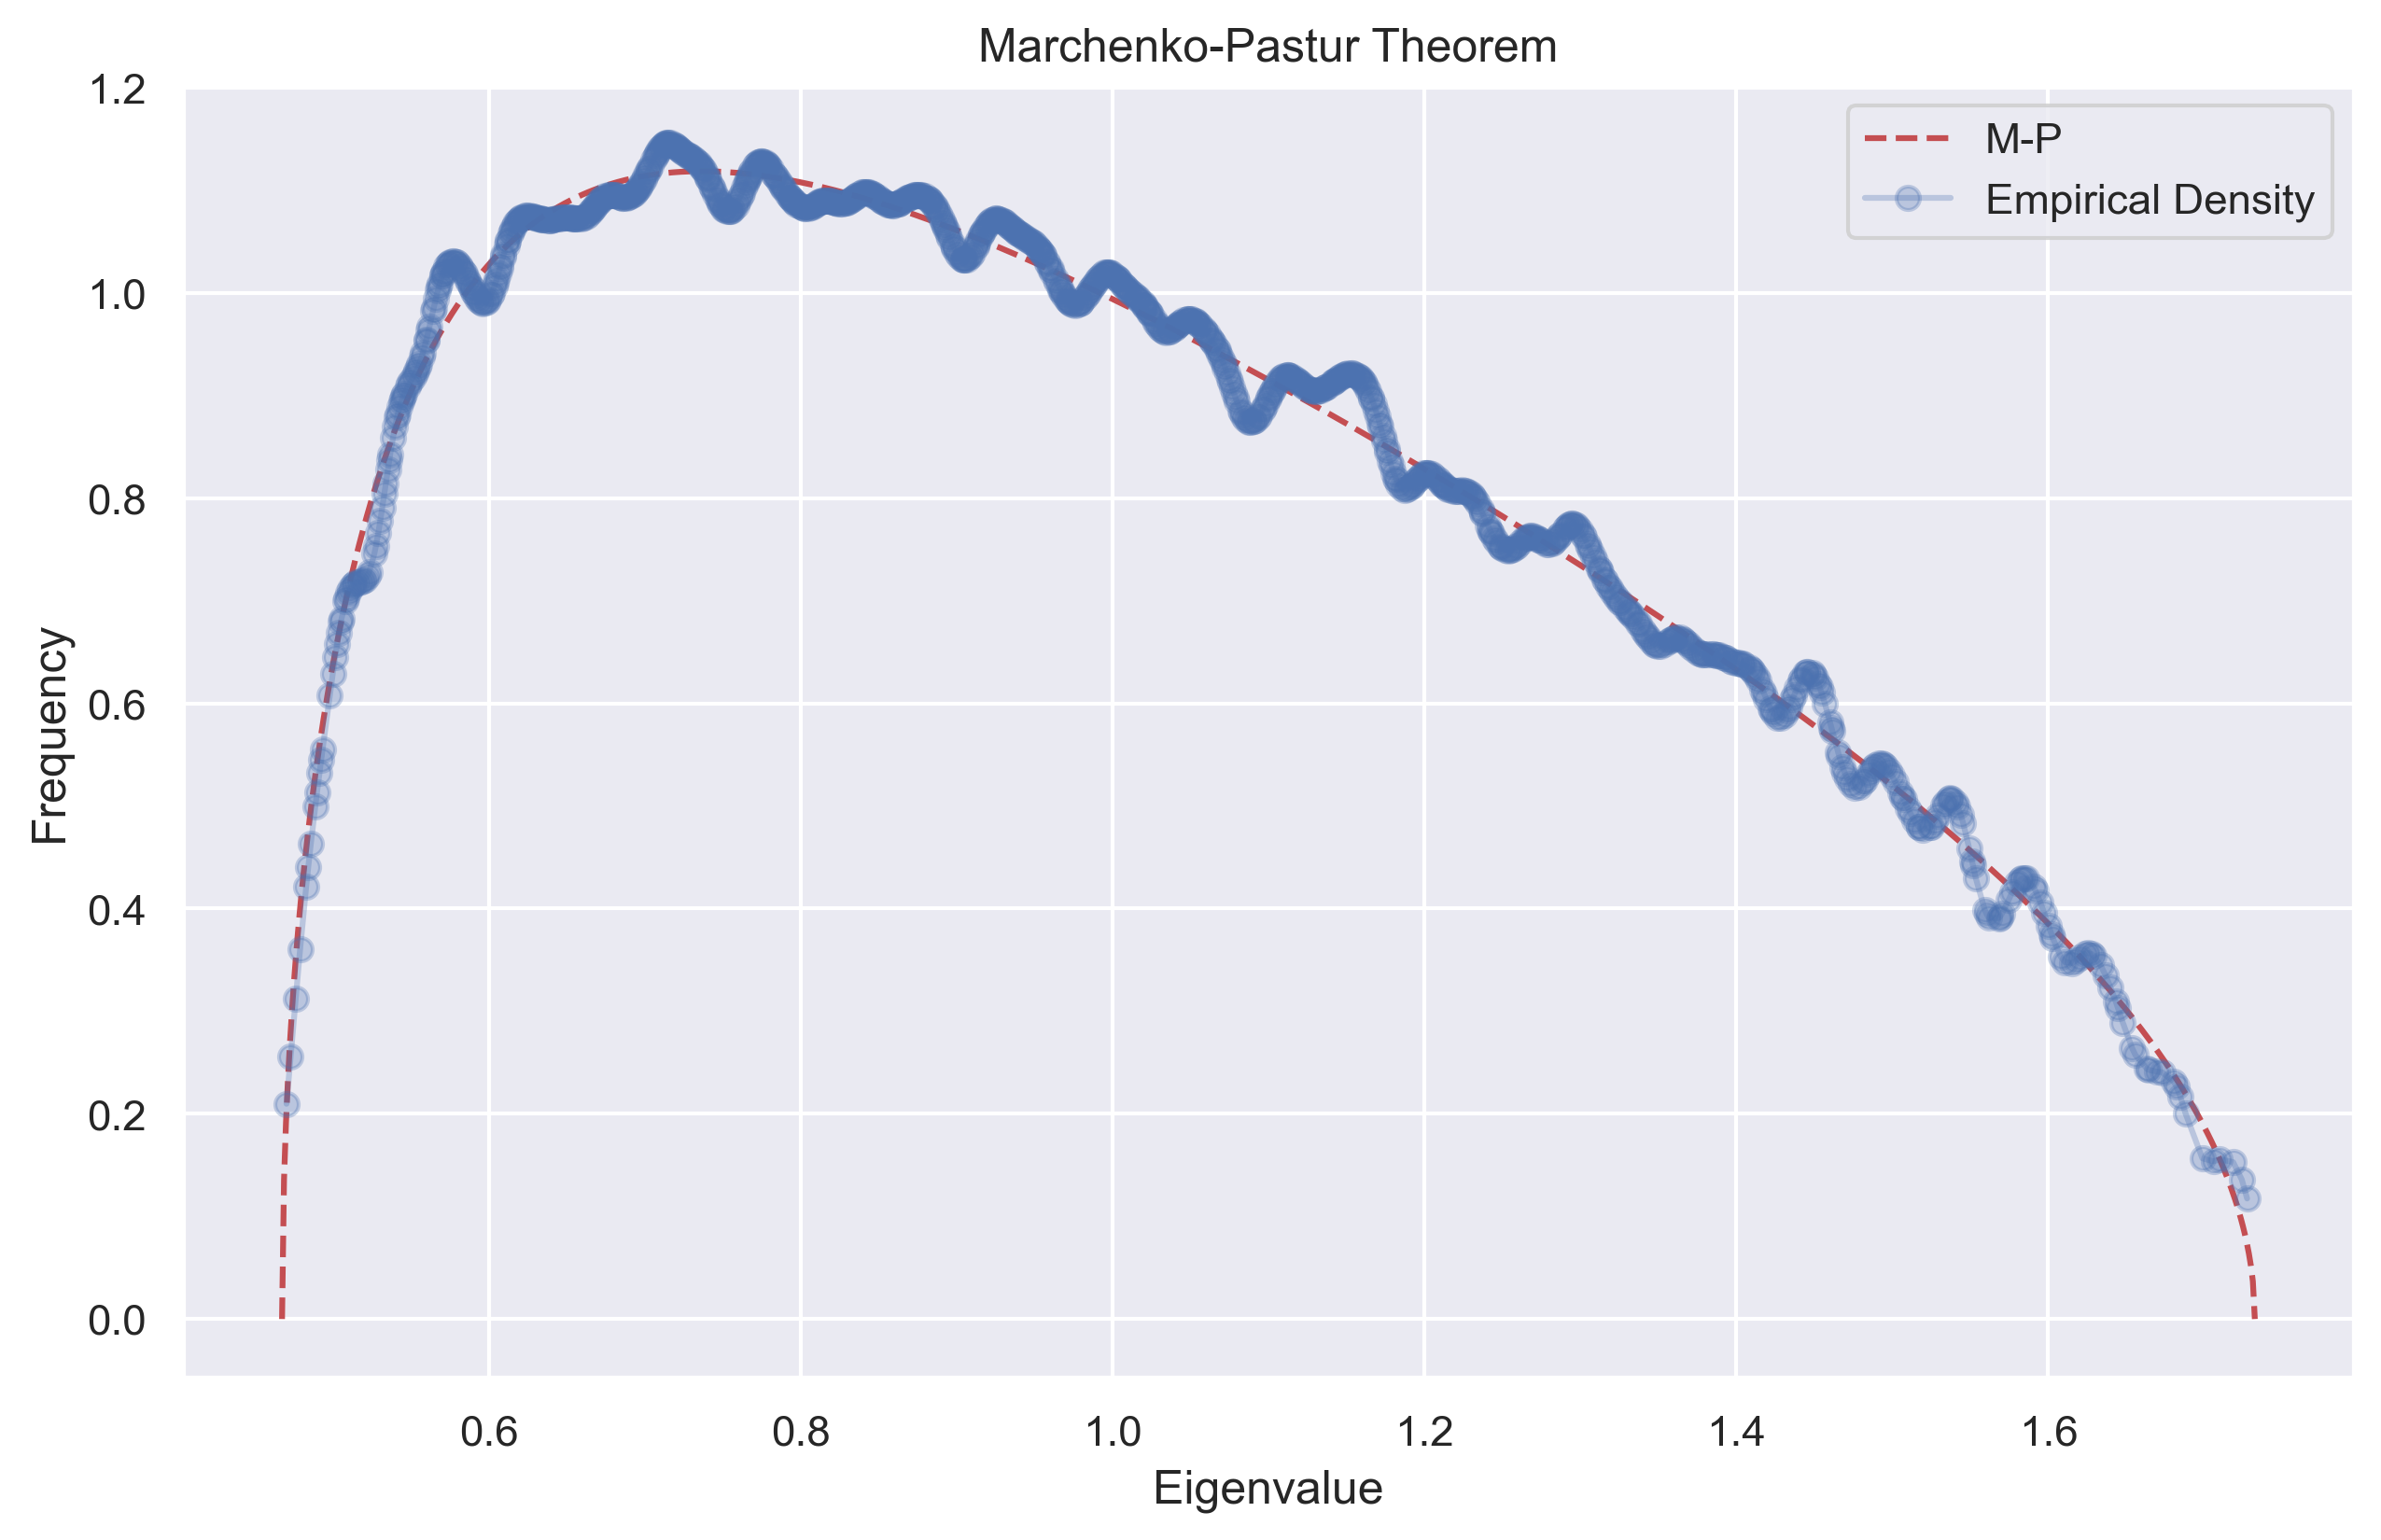

<module 'matplotlib.pyplot' from 'c:\\Users\\kumb2\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
plotting(corr_coef, q)

## Denoising

empirical finance에서 대부분의 경우 공분산을 축소하여 사용하는 것이 일반적이다. 그러나 차원의 축소는 잡음 뿐만 아니라 신호 또한 구분하지 않고 조건의 수를 감소시킨다. 안그래도 약한 신호를 축소를 통해 더욱 약하게 만들 수도 있다. 상관 행렬의 잡음 제거 방법에는 두 가지 방법이 존재한다.

**1. Constant Residual Eigenvalue Method**

이 접근 방식은 모든 랜덤 고유 벡터에 대해 상수 고유값을 설정하는데에 있다. $\{\lambda_n\}_{n=1, \dots, N}$은 모든 고유값의 집합이며, 내림차순이며, $i$는 $\lambda_i > \lambda_+$와 $\lambda_{i+1} \leq \lambda_+$가 되는 고유값의 위치가 된다. 그런 다음 $\lambda_j = \frac{1}{N-i} \sum_{k = i+1}^N \lambda_k, j = i+1, \dots, N$을 설정해 상관 행렬의 대각합을 보존한다. 고유 벡터 분해 $VW = W\Lambda$가 주어질 때 다음과 같이 잡음이 제거된 상관행렬 $C_1$을 형성한다

$$\tilde C_1 = W \tilde\Lambda W^\prime$$
$$C_1 = \tilde C_1\Big[ \big(\mathbb{diag}[\tilde C_1]\big)^\frac{1}{2}
\big(\mathbb{diag}[\tilde C_1]\big)^{\frac{1}{2} \prime}\Big]^{-1}$$



**2. Targeted Shrinkage**

위의 방법은 신호를 보존하면서 잡음을 제거하기 때문에 축소보다는 선호된다. 대안적으로 랜덤 고유 벡터에 대해 엄격한 축소 적용을 목표로 할 수도 있다. 다음의 상관 행렬 $C_1$을 고려하자

$$C_1 = W_L\Lambda_L W_L^\prime + \alpha W_R \Lambda_R W_R^\prime + (1-\alpha) \mathbb{diag}
[W_R \Lambda_R W_R^\prime]$$

여기서 $W_R$과 $\Lambda_R$은 $\{n|\lambda_n \leq \lambda_+\}$와 관련된 고유 벡터와 고유값이고, $W_L$과 $\Lambda_L$은 $\{n|\lambda_n > \lambda_+\}$와 관련된 고유 벡터와 고유값이며, $\alpha$는 잡음과 관련된 고유 벡터와 고유값 사이의 축소량을 조절한다.

공분산 행렬의 잡음을 제거한다면 데이터에서 불필요한 잡음을 제거하고 시장의 신호만을 활용해 중요한 사건에 관련된 위험을 측정할 수 있을 것이다.

다음 코드는 Constant Residual Eigenvalue Method을 이용해 Denoising을 수행한 뒤 해당 공분산 행렬을 이용해 VaR을 계산하는 코드이다.

In [22]:
def mp_pdf(var, q, pts): # q=T/N, pts는 일종의 정밀도
    eMin, eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin, eMax, pts).flatten()
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 # MP pdf based on eigenvalue space
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [23]:
def kde_fit(obs, bandwidth, x=None):
    
    if len(obs.shape) == 1:
        obs=obs.reshape(-1,1)
    kde_fit=KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logprob = kde_fit.score_samples(x)
    pdf_kde = pd.Series(np.exp(logprob), index=x.flatten())
    return pdf_kde

In [24]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts=1000):
    # Fit error
    pdf0=mp_pdf(var, q, pts)  # 이론적 pdf
    pdf1=kde_fit(eVal, bWidth, x=pdf0.index.values)  # 경험적 pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal, q, bWidth):
    out=minimize(lambda *x:errPDFs(*x), .5, args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5), ))
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax, var

In [25]:
def getPCA(matrix):
    eVal, eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1]
    eVal, eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal, eVec

In [26]:
def denoisedCorr(eVal, eVec, nFacts):
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    cov1=np.dot(eVec, eVal_).dot(eVec.T)
    return cov1

In [27]:
def correlation_to_covariance(corr, std):
    cov = corr * np.outer(std, std)
    return cov

In [28]:
# 코로나 시절 Var을 기존과 Denoise 된 Var로 계산산

symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(yf.download(symbol, '2008-05-01', '2009-05-31')['Close'])
stocks = pd.DataFrame(stock3).T
stocks.columns = symbols
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()

stocks_returns_mean = stocks_returns.mean()
weights  = [1/3]*3
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))
stock_cov=np.diag(cov_var)   # 각 종목 분산 데이터
port_return_mean = np.dot(stocks_returns, weights).mean()
initial_investment = 1e6   # 원금 100만 달러에 대해 동일비중 포트폴리오와 각 종목에만 투자하는 세가지 포트폴리오 비교
conf_level = 0.95

eVal, eVec = getPCA(np.corrcoef(stocks_returns, rowvar=False))
eMax, var = findMaxEval(np.diag(eVal), 0.2, 100)
nfacts=eVal.shape[0]-np.diag(eVal)[::-1].searchsorted(eMax)
corr1=denoisedCorr(eVal, eVec, nfacts)
cov1=correlation_to_covariance(corr1, np.sqrt(stock_cov))
port_std_de=np.sqrt(weights.T.dot(cov1).dot(weights))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [29]:
alpha = norm.ppf(1 - conf_level, port_return_mean, port_std_de)
VaR_param_port_de = (initial_investment - initial_investment * (1 + alpha))
print("Parametric VaR result for {} is {} ".format("equal_weight_portfolio + denoiesed var", VaR_param_port_de))

Parametric VaR result for equal_weight_portfolio + denoiesed var is 30268.090538496035 


In [30]:
alpha = norm.ppf(1 - conf_level, port_return_mean, port_std)
VaR_param_port = (initial_investment - initial_investment * (1 + alpha))
print("Parametric VaR result for {} is {} ".format("equal_weight_portfolio", VaR_param_port))

Parametric VaR result for equal_weight_portfolio is 46192.813880467555 


In [31]:
(VaR_param_port-VaR_param_port_de)*100/VaR_param_port_de

52.61224959571827

In [73]:
# 2017년 Var을 기존과 Denoise 된 Var로 계산

symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(yf.download(symbol, '2013-01-01', '2013-12-31')['Close'])
stocks = pd.DataFrame(stock3).T
stocks.columns = symbols
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()

stocks_returns_mean = stocks_returns.mean()
weights  = [1/3]*3
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))
stock_cov=np.diag(cov_var)   # 각 종목 분산 데이터
port_return_mean = np.dot(stocks_returns, weights).mean()
initial_investment = 1e6   # 원금 100만 달러에 대해 동일비중 포트폴리오와 각 종목에만 투자하는 세가지 포트폴리오 비교
conf_level = 0.95

eVal, eVec = getPCA(np.corrcoef(stocks_returns, rowvar=False))
eMax, var = findMaxEval(np.diag(eVal), 3/len(stocks), 100)
nfacts=eVal.shape[0]-np.diag(eVal)[::-1].searchsorted(eMax)
corr1=denoisedCorr(eVal, eVec, nfacts)
cov1=correlation_to_covariance(corr1, np.sqrt(stock_cov))
port_std_de=np.sqrt(weights.T.dot(cov1).dot(weights))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [74]:
alpha = norm.ppf(1 - conf_level, port_return_mean, port_std_de)
VaR_param_port_de = (initial_investment - initial_investment * (1 + alpha))
print("Parametric VaR result for {} is {} ".format("equal_weight_portfolio + denoiesed var", VaR_param_port_de))

Parametric VaR result for equal_weight_portfolio + denoiesed var is 12352.505194895668 


In [75]:
alpha = norm.ppf(1 - conf_level, port_return_mean, port_std)
VaR_param_port = (initial_investment - initial_investment * (1 + alpha))
print("Parametric VaR result for {} is {} ".format("equal_weight_portfolio", VaR_param_port))

Parametric VaR result for equal_weight_portfolio is 14962.776218777755 


In [76]:
(VaR_param_port-VaR_param_port_de)*100/VaR_param_port_de

21.131511241628214

다음은 Denoise된 공분산 행렬의 VaR과 Denoise되지 않은 공분산 행렬의 VaR간 차이를 분석하는 코드이다.

In [36]:
result=[]
for i in range(1990, 2024):
    symbols = ["IBM", "MSFT", "INTC"]
    stock3 = []
    for symbol in symbols:
        stock3.append(yf.download(symbol, str(i)+'-01-01', str(i)+'-12-31')['Close'])
        stocks = pd.DataFrame(stock3).T
    stocks.columns = symbols
    stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()

    stocks_returns_mean = stocks_returns.mean()
    weights  = [1/3]*3
    weights /= np.sum(weights)
    cov_var = stocks_returns.cov()
    port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))
    stock_cov=np.diag(cov_var)   # 각 종목 분산 데이터
    port_return_mean = np.dot(stocks_returns, weights).mean()
    initial_investment = 1e6   # 원금 100만 달러에 대해 동일비중 포트폴리오와 각 종목에만 투자하는 세가지 포트폴리오 비교
    conf_level = 0.95

    eVal, eVec = getPCA(np.corrcoef(stocks_returns, rowvar=False))
    eMax, var = findMaxEval(np.diag(eVal), 0.2, 100)
    nfacts=eVal.shape[0]-np.diag(eVal)[::-1].searchsorted(eMax)
    corr1=denoisedCorr(eVal, eVec, nfacts)
    cov1=correlation_to_covariance(corr1, np.sqrt(stock_cov))
    port_std_de=np.sqrt(weights.T.dot(cov1).dot(weights))

    alpha = norm.ppf(1 - conf_level, port_return_mean, port_std_de)
    VaR_param_port_de = (initial_investment - initial_investment * (1 + alpha))

    alpha = norm.ppf(1 - conf_level, port_return_mean, port_std)
    VaR_param_port = (initial_investment - initial_investment * (1 + alpha))

    result.append([i, (VaR_param_port-VaR_param_port_de)*100/VaR_param_port_de])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [37]:
df_snp=yf.download( '^GSPC', start='1990-01-01', end='2023-12-31', interval='1d')['Close']
df_snp=pd.DataFrame(df_snp)
df_snp['year']=df_snp.index.year
df_year=df_snp.groupby(['year'])['Close'].mean()
df_year=pd.DataFrame(df_year)
df_year.columns=['value']

[*********************100%%**********************]  1 of 1 completed


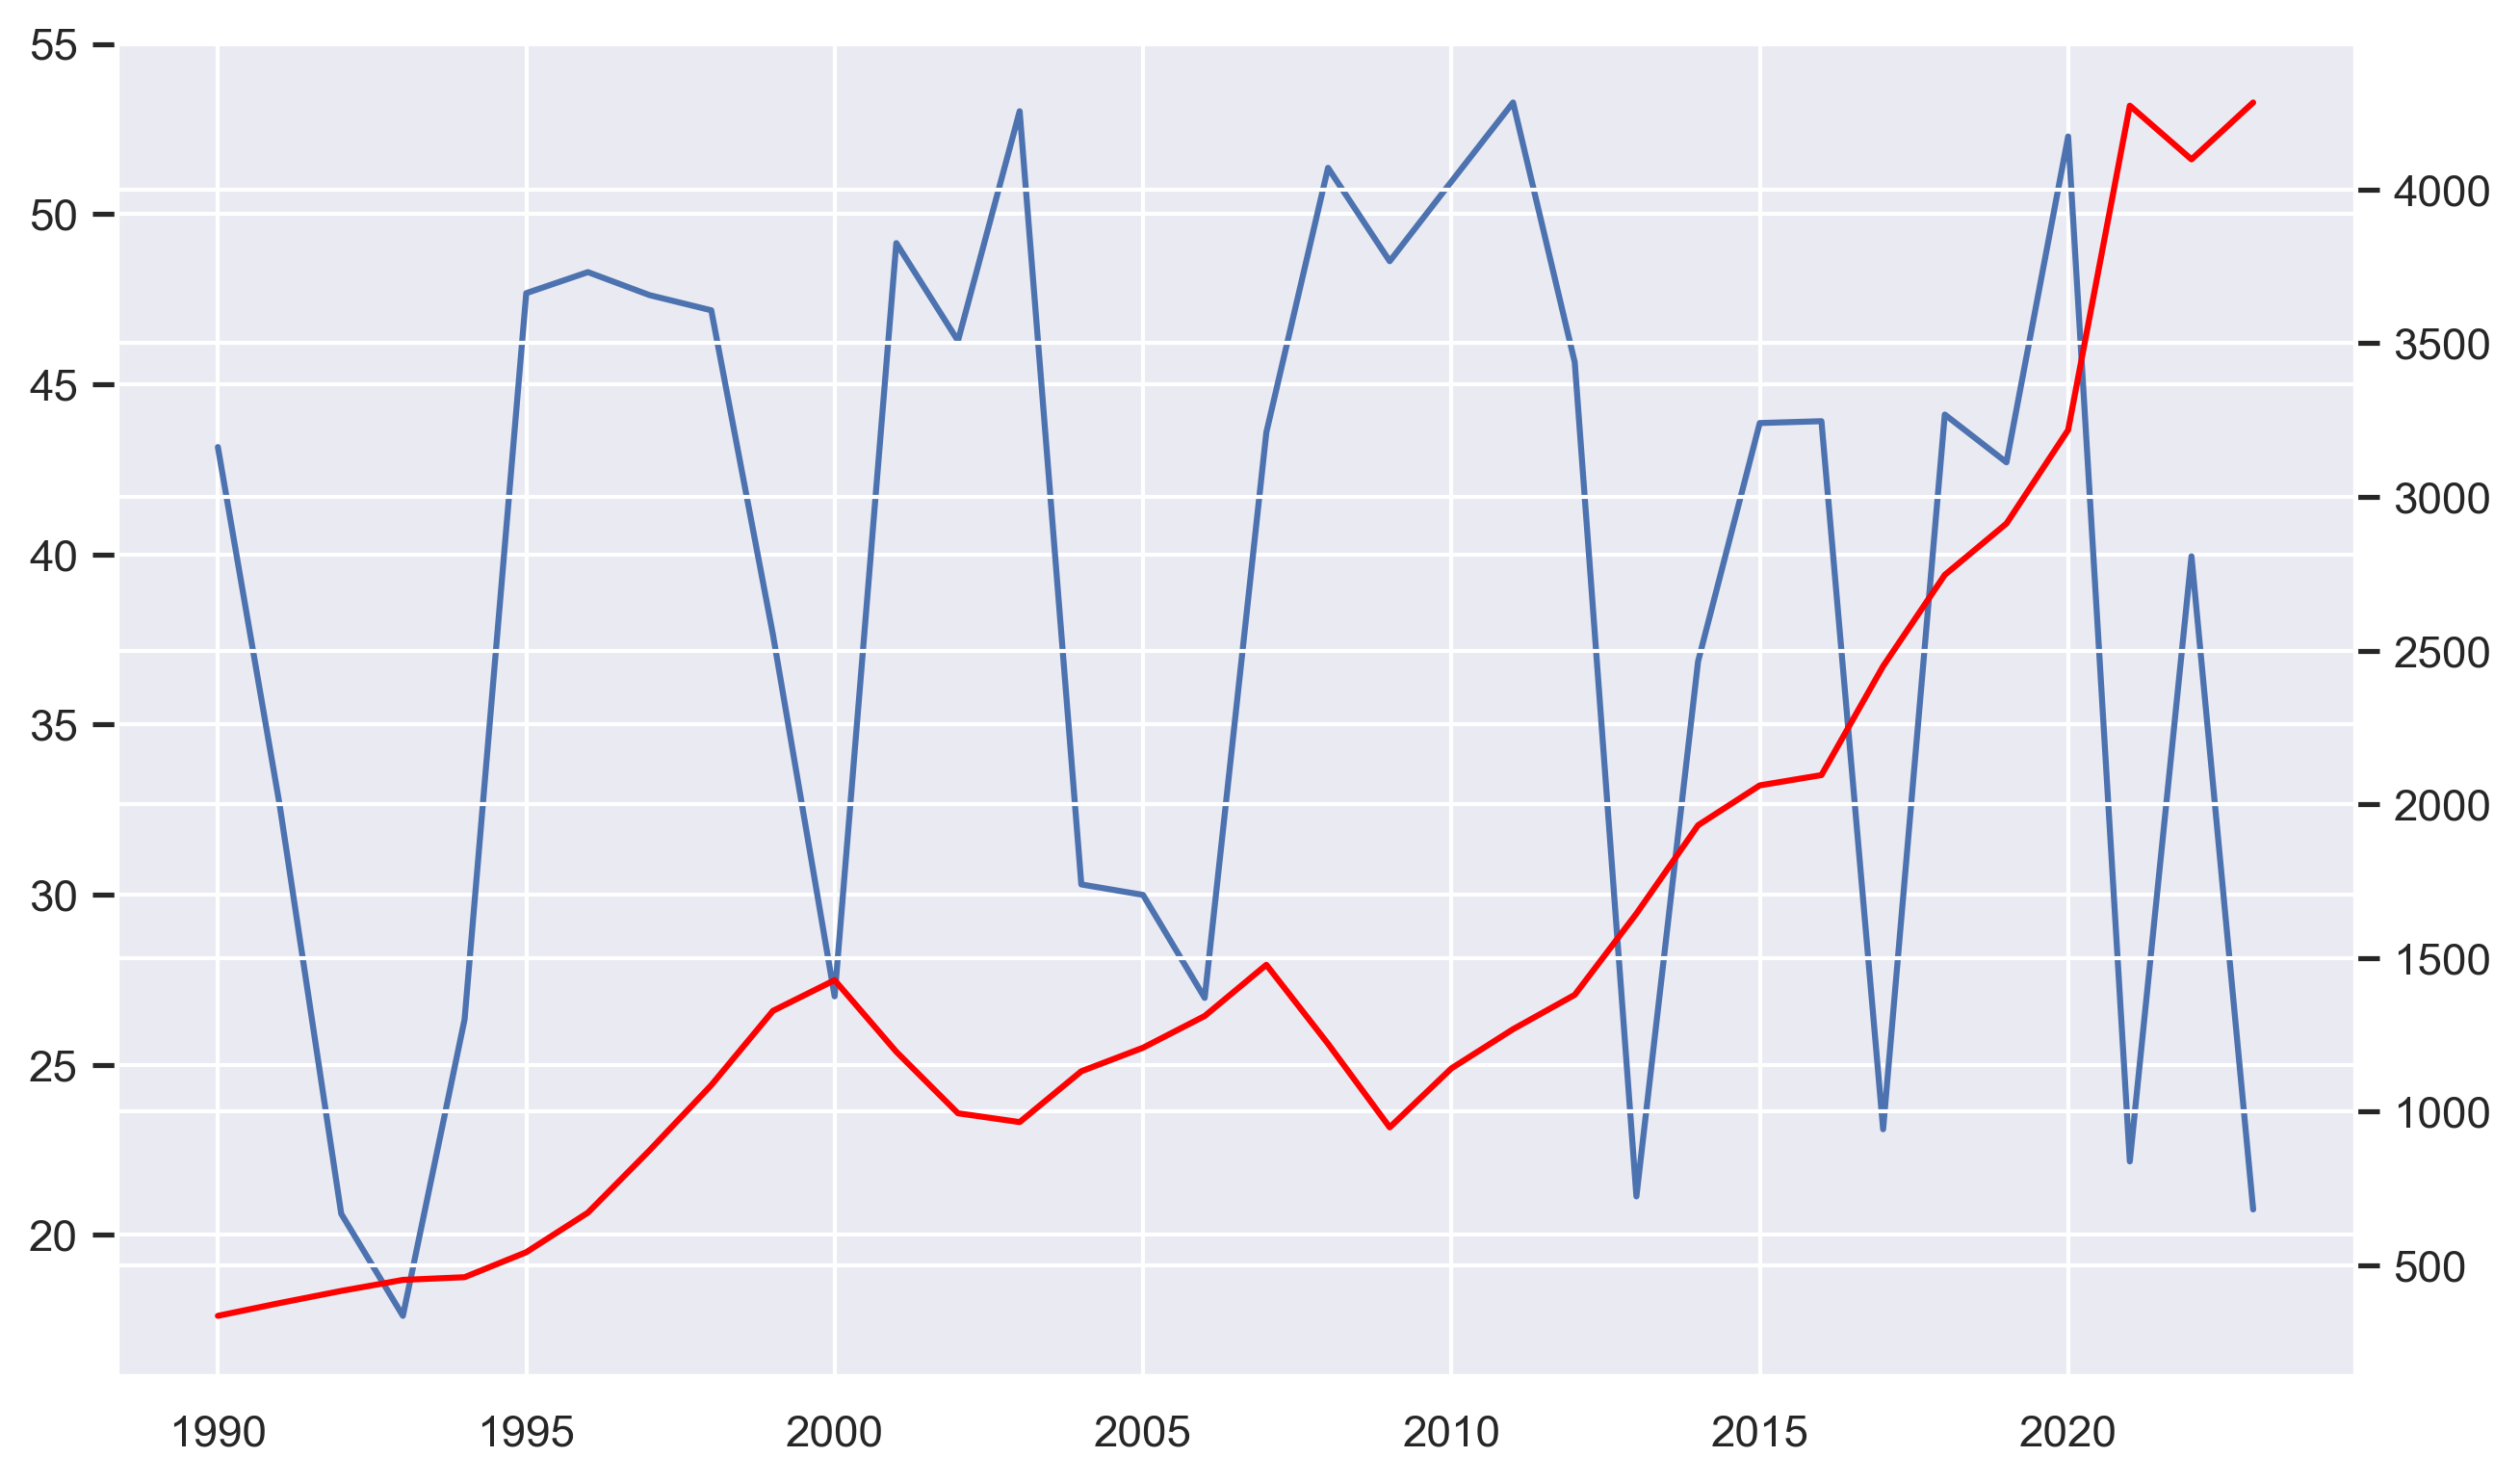

In [38]:
df=pd.DataFrame(result)
df.columns=['year', 'delta']
fig, ax1 = plt.subplots()
ax1.plot(df.year, df.delta)
ax2 = ax1.twinx()
ax2.plot(df_year.index, df_year.value, color='red')
plt.show()

## Checking Sub-additivity

일관된 위험 측정을 위해서는 4가지 공리를 만족해야 한다.

**Subadditivity** 
$$ ρ (X + Y ) ≤ ρ (X) + ρ (Y )$$

**Homogeneity** 

For any number α > 0, $$ρ (αX) = αρ (X)$$

**Monotonicity**
$$ρ (Y ) ≥ ρ (X) \ if \  X ≤ Y$$

**Risk Free Condition**

for any constant k, $$ρ (X + k) = ρ (X) − k $$

하지만 VaR은 Subadditivity를 충족하지 못한다는 한계점을 가진다. 대부분 Subadditivity를 충족하나, 특별한 Case에서는 Subadditivity를 만족하지 못한다.

In [39]:
asset1 = [-0.5, 0, 0.1, 0.4]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.01, 0.4]
VaR2 = np.percentile(asset2, 90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2, 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

VaR for the Asset 1 is 0.3100
VaR for the Asset 2 is 0.2830
VaR for the portfolio is 0.4000


In [40]:
asset1 = [-0.5, 0, 0.05, 0.03]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.02, 0.8]
VaR2 = np.percentile(asset2,90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2 , 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

VaR for the Asset 1 is 0.0440
VaR for the Asset 2 is 0.5660
VaR for the portfolio is 0.2750


다음은 Subadditivity를 만족하지 못하는 예시이다.

Consider two assets X and Y that are usually normally distributed, but subject to the occasional independent shocks:
$$ X =  + η, \ \epsilon ∼ IID  \ N (0, 1), \ 

η =\begin{cases}
 0 \ with \ probability \ 0.991, \newline
−10\ with \ probability \ 0.009,
\end{cases}
$$
In this case the 1% $VaR$ is $3.1$, since the probability that $η$ is $-10$ is less than $1%$. Suppose that $Y$ has the same distribution independently from $X$, and
that we formulate an equally weighted portfolio of $X$ and $Y$ . In that case, the 1% portfolio $VaR$ is $9.8$, because for $(X + Y )$ the probability of getting the −10 draw for either $X$ or $Y$ is much higher. $$VaR(X + Y )=9.8 > VaR(X) + VaR(Y )=3.1+3.1=6.2$$

자세한 내용은  ``` Subadditivity Re–Examined: the Case for Value–at–Risk ``` 논문을 참고하도록 하자.

## Expected Shortfall

최대 손실 평균, ES는 CVaR이라고도 불린다. ES는 VaR을 초과하는 손실의 평균이다. 즉 $$ES=E(L\vert L>VaR_\alpha)$$

이는 수익률 $x$의 확률분포함수를 $f(x)$라고 할 때,

$$ES = CVar =   -\frac{1}{1-\alpha} \int_{-\infty} ^{-var} xf(x)dx $$

로 계산할 수 있으며, $\alpha$는 신뢰수준이다.

이때 마이너스를 붙이는 이유는 ES가 음수로 계산되기 때문에 이를 양수로 만들어주기 위함이다.

ES를 손실분포의 분위수를 바탕으로 정의하면

$$ES=\frac{1}{1-\alpha} \int_{\alpha}^1 q_u \ du$$

로 정의할 수 있다. 이러한 정의에서 ES는 손실의 $(1-\alpha)$의 확률가중평균이라는 사실을 알 수 있다.



다음은 VaR과 CVaR을 표현한 그림이다 

<center>
    
<img src="./cvar.png" width="700px" height="400px">
    
</center>

In [41]:
def ES_parametric(initial_investment , conf_level, sigma):
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        alpha = - norm.ppf(1 - conf_level,stocks_returns_mean, sigma[j])
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) * initial_investment \
                   * norm.expect(lambda x: x,
                                 lb = norm.ppf(conf_level,
                                               stocks_returns_mean[j],
                                               sigma[j]),
                                 loc = stocks_returns_mean[j],
                                 scale = sigma[j])
        print(f"Parametric ES result for {i} is {ES_param}")

In [42]:
ES_parametric(initial_investment, conf_level, np.sqrt(np.diag(cov_var)))

Parametric ES result for IBM is 21580.9468777997
Parametric ES result for MSFT is 34322.23591572754
Parametric ES result for INTC is 52527.935971147934


In [43]:
def ES_historical(initial_investment, conf_level):
    for i, j in zip(stocks_returns.columns, 
                    range(len(stocks_returns.columns))):
        ES_hist_percentile95 = np.percentile(stocks_returns.loc[:, i],
                                             5)
        ES_historical = stocks_returns[str(i)][stocks_returns[str(i)] <=
                                               ES_hist_percentile95]\
                                               .mean()
        print("Historical ES result for {} is {:.4f} "
              .format(i, initial_investment * ES_historical))

In [44]:
ES_historical(initial_investment, conf_level)

Historical ES result for IBM is -22850.6300 
Historical ES result for MSFT is -29684.2272 
Historical ES result for INTC is -49734.6319 


In [45]:
import scipy.stats as stats
import scipy

mu=stocks_returns_mean
sigma=np.sqrt(np.diag(cov_var))

s0 = 1e6
normalVar = s0*(-mu+1.65*sigma)

for i in range(3):
    print( -scipy.integrate.quad(lambda x: stats.norm.pdf(x,loc=s0*(mu.iloc[i]),scale = s0*sigma[i])*x, -np.inf, -normalVar.iloc[i])[0] / 0.05)

20249.414852663784
30445.94643662322
47062.59862006363


## Bid-Ask Spread

지금까지는 시장 위험에 대해 학습했다. 하지만 시장 위험과 유동성 위험, 신용 위험 등이 완전하게 독립인 것은 아니다. 오히려 상관 관계를 가지고 있다. 특히 금융 위기가 닥치면 신용 위험, 시장 위험, 유동성 리스크가 함께 급증하는 현상을 보인다.

즉 리스크의 유동성 차원을 무시한다면 시장 리스크의 과소평가로 이어질 가능성이 존재한다. 따라서 유동성 위험이 있는 ES를 추가한다면 더 정확하고 신뢰성 있는 추정이 가능하다.

Bid-Ask Spread는 구매자가 지불할 의사가 있는 가장 높은 가격(매수가)와 판매자가 받을 의사가 있는 가장 낮은 가격(매도가)의 차이이다. 따라서 Bid-Ask Spread는 거래 비용을 측정할 수 있는 도구로써 유동성을 모델링하는데 사용된다.

유동성 위험을 ES 모델에 통합하기 위한 스프레드 모델로 4가지가 언급된다.

**1. 유효 스프레드**
$$\mathbb{유효스프레드} = \ 2\vert(P_t-P_{mid})\vert$$

여기서 $P_t$는 시간 t에서의 거래 가격, $P_{mid}$는 t 시점에 우세한 매수-매도 제안$((P_{ask}-P_{bid})/2)$의 중간점이다.


**2. 비례 호가 스프레드**
$$\mathbb{비례 호가 스프레드}=\ (P_{ask}-P_{bid})/P_{mid}$$

여기서 $P_{ask}$는 매도 호가, $P_{bid}$는 매수 호가, $P_{mid}$는 매수 매도 호가의 중간점을 의미한다.

**3. 명목 스프레드**
$$\mathbb{명목 스프레드}=P_{ask}-P_{bid}$$

**4. 비례 유효 스프레드**
$$\mathbb{비례 유효 스프레드}= \ 2(\vert P_t-P_{mid} \vert)/P_{mid}$$

### 유효 비용

매수자 개시 거래는 거래가 인용된 중간 가격보다 높은 가격으로 채결된 거래를 의미하며, 매도자 개시 거래는 거래가 인용된 중간 가격보다 낮은 가격으로 채결될 때 발생한다. 이를 정리하면

$$\mathbb{유효비용}=\begin{cases}
 (P_t-P_{mid})/P_{mid} \ \ \  \mathbb{매수자 개시의 경우}, \newline
(P_{mid}-P_t)/P_{mid} \ \ \  \mathbb{매수자 개시의 경우}
\end{cases}$$

이제 시장 위험과 유동성 위험 모두를 포함할 수 있게 ES모델을 통합하는 방법에 대해 알아보자. 이를 위한 방법으로는 2가지가 존재하는데, 첫 번째 방법은 매수-매도 스프레드의 단면 평균을 취하는 방법이며 두 번째 방법은 PCA를 적용하는 것이다.

**단면 평균**

단면 평균을 적용하는 방법에 대해 알아보자. 단면 평균은 매수-매도 스프레드의 행 평균이다. 이를 이용해 시장 전체의 유동성을 측정할 수 있다. 평균화 공식은 다음과 같다.

$$L_{M,t}=\frac{1}{N}\Sigma_{i}^N L_{i,t}$$

여기서 $L_{M,t}$는 시장 유동성, $L_{i,t}$는 개별 유동성, 이 케이스에서는 매수-매도 호가 스프레드를 의미한다. 이를 바탕으로 다음과 같이 ES 계산식을 수정할 수 있다.

$$ES_L=ES+\mathtt{유동성비용} \newline
ES_L=\frac{1}{1-\alpha} \int_{\alpha}^1 VaR_u \ du + \frac{1}{2}P_{last}(\mu + k\sigma)$$

여기서

- $P_{last}$는 주식 종가
- $\mu$는 스프레드 평균
- $k$는 두터운 꼬리를 수용하기 위한 스케일링 팩터
- $\sigma$는 스프레드의 표준편차

를 의미한다


다음은 위의 방법론을 코드로 표현한 것이다

In [46]:
bid_ask = pd.read_csv('bid_ask.csv')

In [47]:
bid_ask['mid_price'] = (bid_ask['ASKHI'] + bid_ask['BIDLO']) / 2
buyer_seller_initiated = []
for i in range(len(bid_ask)):
    if bid_ask['PRC'][i] > bid_ask['mid_price'][i]:
        buyer_seller_initiated.append(1)
    else:
        buyer_seller_initiated.append(0)
        
bid_ask['buyer_seller_init'] = buyer_seller_initiated   

In [48]:
effective_cost = []
for i in range(len(bid_ask)):
    if bid_ask['buyer_seller_init'][i] == 1:
        effective_cost.append((bid_ask['PRC'][i] - 
                               bid_ask['mid_price'][i]) / 
                               bid_ask['mid_price'][i])
    else:
        effective_cost.append((bid_ask['mid_price'][i] - 
                               bid_ask['PRC'][i])/
                               bid_ask['mid_price'][i])
bid_ask['effective_cost'] = effective_cost

In [49]:
bid_ask['quoted'] = bid_ask['ASKHI'] - bid_ask['BIDLO']
bid_ask['prop_quoted'] = (bid_ask['ASKHI'] - bid_ask['BIDLO']) /\
                         bid_ask['mid_price']
bid_ask['effective'] = 2 * abs(bid_ask['PRC'] - bid_ask['mid_price'])
bid_ask['prop_effective'] = 2 * abs(bid_ask['PRC'] - 
                                    bid_ask['mid_price']) /\
                                    bid_ask['PRC']

In [50]:
spread_meas = bid_ask.iloc[:, -5:]
spread_meas.corr()

,effective_cost,quoted,prop_quoted,effective,prop_effective
effective_cost,1.000000,0.441290,0.727917,0.800894,0.999847
quoted,0.441290,1.000000,0.628526,0.717246,0.442053
prop_quoted,0.727917,0.628526,1.000000,0.514979,0.728687
effective,0.800894,0.717246,0.514979,1.000000,0.800713
prop_effective,0.999847,0.442053,0.728687,0.800713,1.000000


In [51]:
spread_meas.describe()

,effective_cost,quoted,prop_quoted,effective,prop_effective
count,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.004247,1.592583,0.015869,0.844314,0.008484
std,0.003633,0.921321,0.007791,0.768363,0.007257
min,0.000000,0.320000,0.003780,0.000000,0.000000
25%,0.001517,0.979975,0.010530,0.300007,0.003029
50%,0.003438,1.400000,0.013943,0.610000,0.006874
75%,0.005854,1.962508,0.019133,1.180005,0.011646
max,0.023283,8.110000,0.055451,6.750000,0.047677


In [52]:
high_corr = spread_meas.corr().unstack()\
            .sort_values(ascending=False).drop_duplicates()
high_corr[(high_corr > 0.80) & (high_corr != 1)]

prop_effective  effective_cost    0.999847
effective_cost  effective         0.800894
prop_effective  effective         0.800713
dtype: float64

In [53]:
sorted_spread_measures = bid_ask.iloc[:, -5:-2]

In [54]:
cross_sec_mean_corr = sorted_spread_measures.mean(axis=1).mean()
std_corr = sorted_spread_measures.std().sum() / 3

In [55]:
df = pd.DataFrame(index=stocks.columns)
last_prices = []
for i in symbols:
    last_prices.append(stocks[i].iloc[-1])
df['last_prices'] = last_prices

In [56]:
def ES_parametric(initial_investment, conf_level):
    ES_params = [ ]
    alpha = - norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i,j in zip(stocks.columns,range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
                   * norm.expect(lambda x: VaR_param, lb = conf_level)
        ES_params.append(ES_param)
    return ES_params

In [57]:
ES_params = ES_parametric(initial_investment, conf_level)
for i in range(len(symbols)):
    print(f'The ES result for {symbols[i]} is {ES_params[i]}')

The ES result for IBM is 66272.03868459024
The ES result for MSFT is 62063.06315946695
The ES result for INTC is 59584.248460779985


In [58]:
k = 1.96

for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) * 
                  (cross_sec_mean_corr + k * std_corr)))

The liquidity Adjusted ES of IBM is 66365.83131062951
The liquidity Adjusted ES of MSFT is 62278.71451525503
The liquidity Adjusted ES of INTC is 59613.06582165146


## PCA

PCA는 데이터의 차원을 줄이는데 많이 사용된다. 더 엄밀하게 말하면, PCA는 데이터의 projection에 의해 계산된 가장 큰 분산을 만드는 좌표계를 첫번째 주성분으로, 두번째로 큰 분산을 만들도록 하는 좌표계를 두번째 주성분으로 만들게 하는 Orthogonal Linear Transformation으로 정의된다. $n\times p$인 matrix $\mathbf{x}$가 있다고 하자. 여기서 n개의 열은 관측치를 나타내고 p개의 행은 feature의 개수로 가정한다 (일반적인 Feature Matrix라고 생각하면 된다)

수학적으로, Transformation은 $\mathbf{x}$의 각 행 벡터 $\mathbf{x}_{i}$ 를 주성분 점수 ${\displaystyle \mathbf {t}_{(i)}=(t_{1}} \dots,t_{l})_{(i)}$의 새로운 벡터에 매핑하는 가중치 또는 계수 $\mathbf{w}_{k}$의 크기 $l$로 정의된다

$$\displaystyle {t_{k}}_{(i)}=\mathbf{{x}_{(i)}\cdot \mathbf {w} _{(k)}\qquad \mathrm {for} \qquad i=1,\dots ,n\qquad k=1,\dots ,l}$$

데이터의 분산을 가장 크게 만드는 첫 번째 주성분 좌표계를 구하기 위한 가중치 벡터 $\mathbf{w}_{(1)}$은 다음을 만족한다

$${\displaystyle \mathbf {w} _{(1)}=\arg \max _{\Vert \mathbf {w} \Vert =1}\,\left\{\sum _{i}(t_{1})_{(i)}^{2}\right\}=\arg \max _{\Vert \mathbf {w} \Vert =1}\,\left\{\sum _{i}\left(\mathbf {x} _{(i)}\cdot \mathbf {w} \right)^{2}\right\}}$$

위 식은 아래와 같이 다시 쓸 수 있다

$${\displaystyle \mathbf {w} _{(1)}=\arg \max _{\left\|\mathbf {w} \right\|=1}\left\{\left\|\mathbf {Xw} \right\|^{2}\right\}=\arg \max _{\left\|\mathbf {w} \right\|=1}\left\{\mathbf {w} ^{\mathsf {T}}\mathbf {X} ^{\mathsf {T}}\mathbf {Xw} \right\}}$$

$\mathbf{w}_{(1)}$은 unit vector로 정의되기 때문에, 아래를 만족한다

$${\displaystyle \mathbf {w} _{(1)}=\arg \max \left\{{\frac {\mathbf {w} ^{\mathsf {T}}\mathbf {X} ^{\mathsf {T}}\mathbf {Xw} }{\mathbf {w} ^{\mathsf {T}}\mathbf {w} }}\right\}}$$

최대화하고자 하는 양은 Rayleigh quotient으로 인식될 수 있다. $\mathbf{X}^{\mathsf {T}}\mathbf{X}$와 같은 양의 반정의 행렬에 대한 표준 결과는 가능한 몫의 최대치가 행렬의 가장 큰 고유값이며, 이는 w가 대응하는 고유 벡터일 때 발생한다


k번째 주성분은 $\mathbf{x}$에서 첫번째 ~ k-1 주성분을 빼면 알 수 있다

$${\displaystyle \mathbf {\hat {X}} _{k}=\mathbf {X} -\sum _{s=1}^{k-1}\mathbf {X} \mathbf {w} _{(s)}\mathbf {w} _{(s)}^{\mathsf {T}}}$$

새롭게 도출된 matrix에서 variance를 가장 크게 하는 가중치 벡터 $\mathbf{w}$를 찾는다

$${\displaystyle \mathbf {w} _{(k)}=\mathop {\operatorname {arg\,max} } _{\left\|\mathbf {w} \right\|=1}\left\{\left\|\mathbf {\hat {X}} _{k}\mathbf {w} \right\|^{2}\right\}=\arg \max \left\{{\tfrac {\mathbf {w} ^{\mathsf {T}}\mathbf {\hat {X}} _{k}^{\mathsf {T}}\mathbf {\hat {X}} _{k}\mathbf {w} }{\mathbf {w} ^{T}\mathbf {w} }}\right\}}$$

이것은 $\mathbf{X}^{\mathsf {T}}\mathbf{X}$의 나머지 고유 벡터에 해당하는 고유값으로 주어진 괄호 안의 양에 대한 최대값을 제공힌디. 따라서 가중치 벡터는 $\mathbf{X}^{\mathsf {T}}\mathbf{X}$의 **eigenvector**이다

따라서 데이터 벡터 $\mathbf{x}^{(i)}$의 k번째 주성분은 변환된 좌표에서 점수 $t_{k(i)} = \mathbf{x}_{(i)} ⋅ \mathbf{w}_{(k)}$로 표시되거나 원래 변수의 공간에서 해당 벡터인 $\mathbf{x}_{(i)} ⋅ \mathbf{w}_{(k)}$로 표시될 수 있습니다. 여기서 $\mathbf{w}_{(k)}$는 $\mathbf{X}^{\mathsf {T}}\mathbf{X}$의 $k$번째 eigenvector이다

따라서 $\mathbf{X}$의 전체 주성분 분해는 다음과 같이 나타낼 수 있다

$$\mathbf{T} = \mathbf{XW}$$

여기서 $\mathbf{W}$는 $\mathbf{X}^{\mathsf {T}}\mathbf{X}$의 eignevector의 $p \times p$ 가중치 행렬이다


이 예시에서는 PCA를 이용해 유동성의 독특한 특징을 얻을 수 있어 PCA를 사용한다.

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [60]:
scaler = StandardScaler()
spread_meas_scaled = scaler.fit_transform(np.abs(spread_meas))
pca = PCA(n_components=5)
prin_comp = pca.fit_transform(spread_meas_scaled)

In [61]:
var_expl = np.round(pca.explained_variance_ratio_, decimals=4)
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                             decimals=4))
print('Individually Explained Variances are:\n{}'.format(var_expl)) 
print('=='*30)
print('Cumulative Explained Variances are: {}'.format(cum_var))  

Individually Explained Variances are:
[0.7494 0.1461 0.0983 0.0062 0.    ]
Cumulative Explained Variances are: [0.7494 0.8955 0.9938 1.     1.    ]


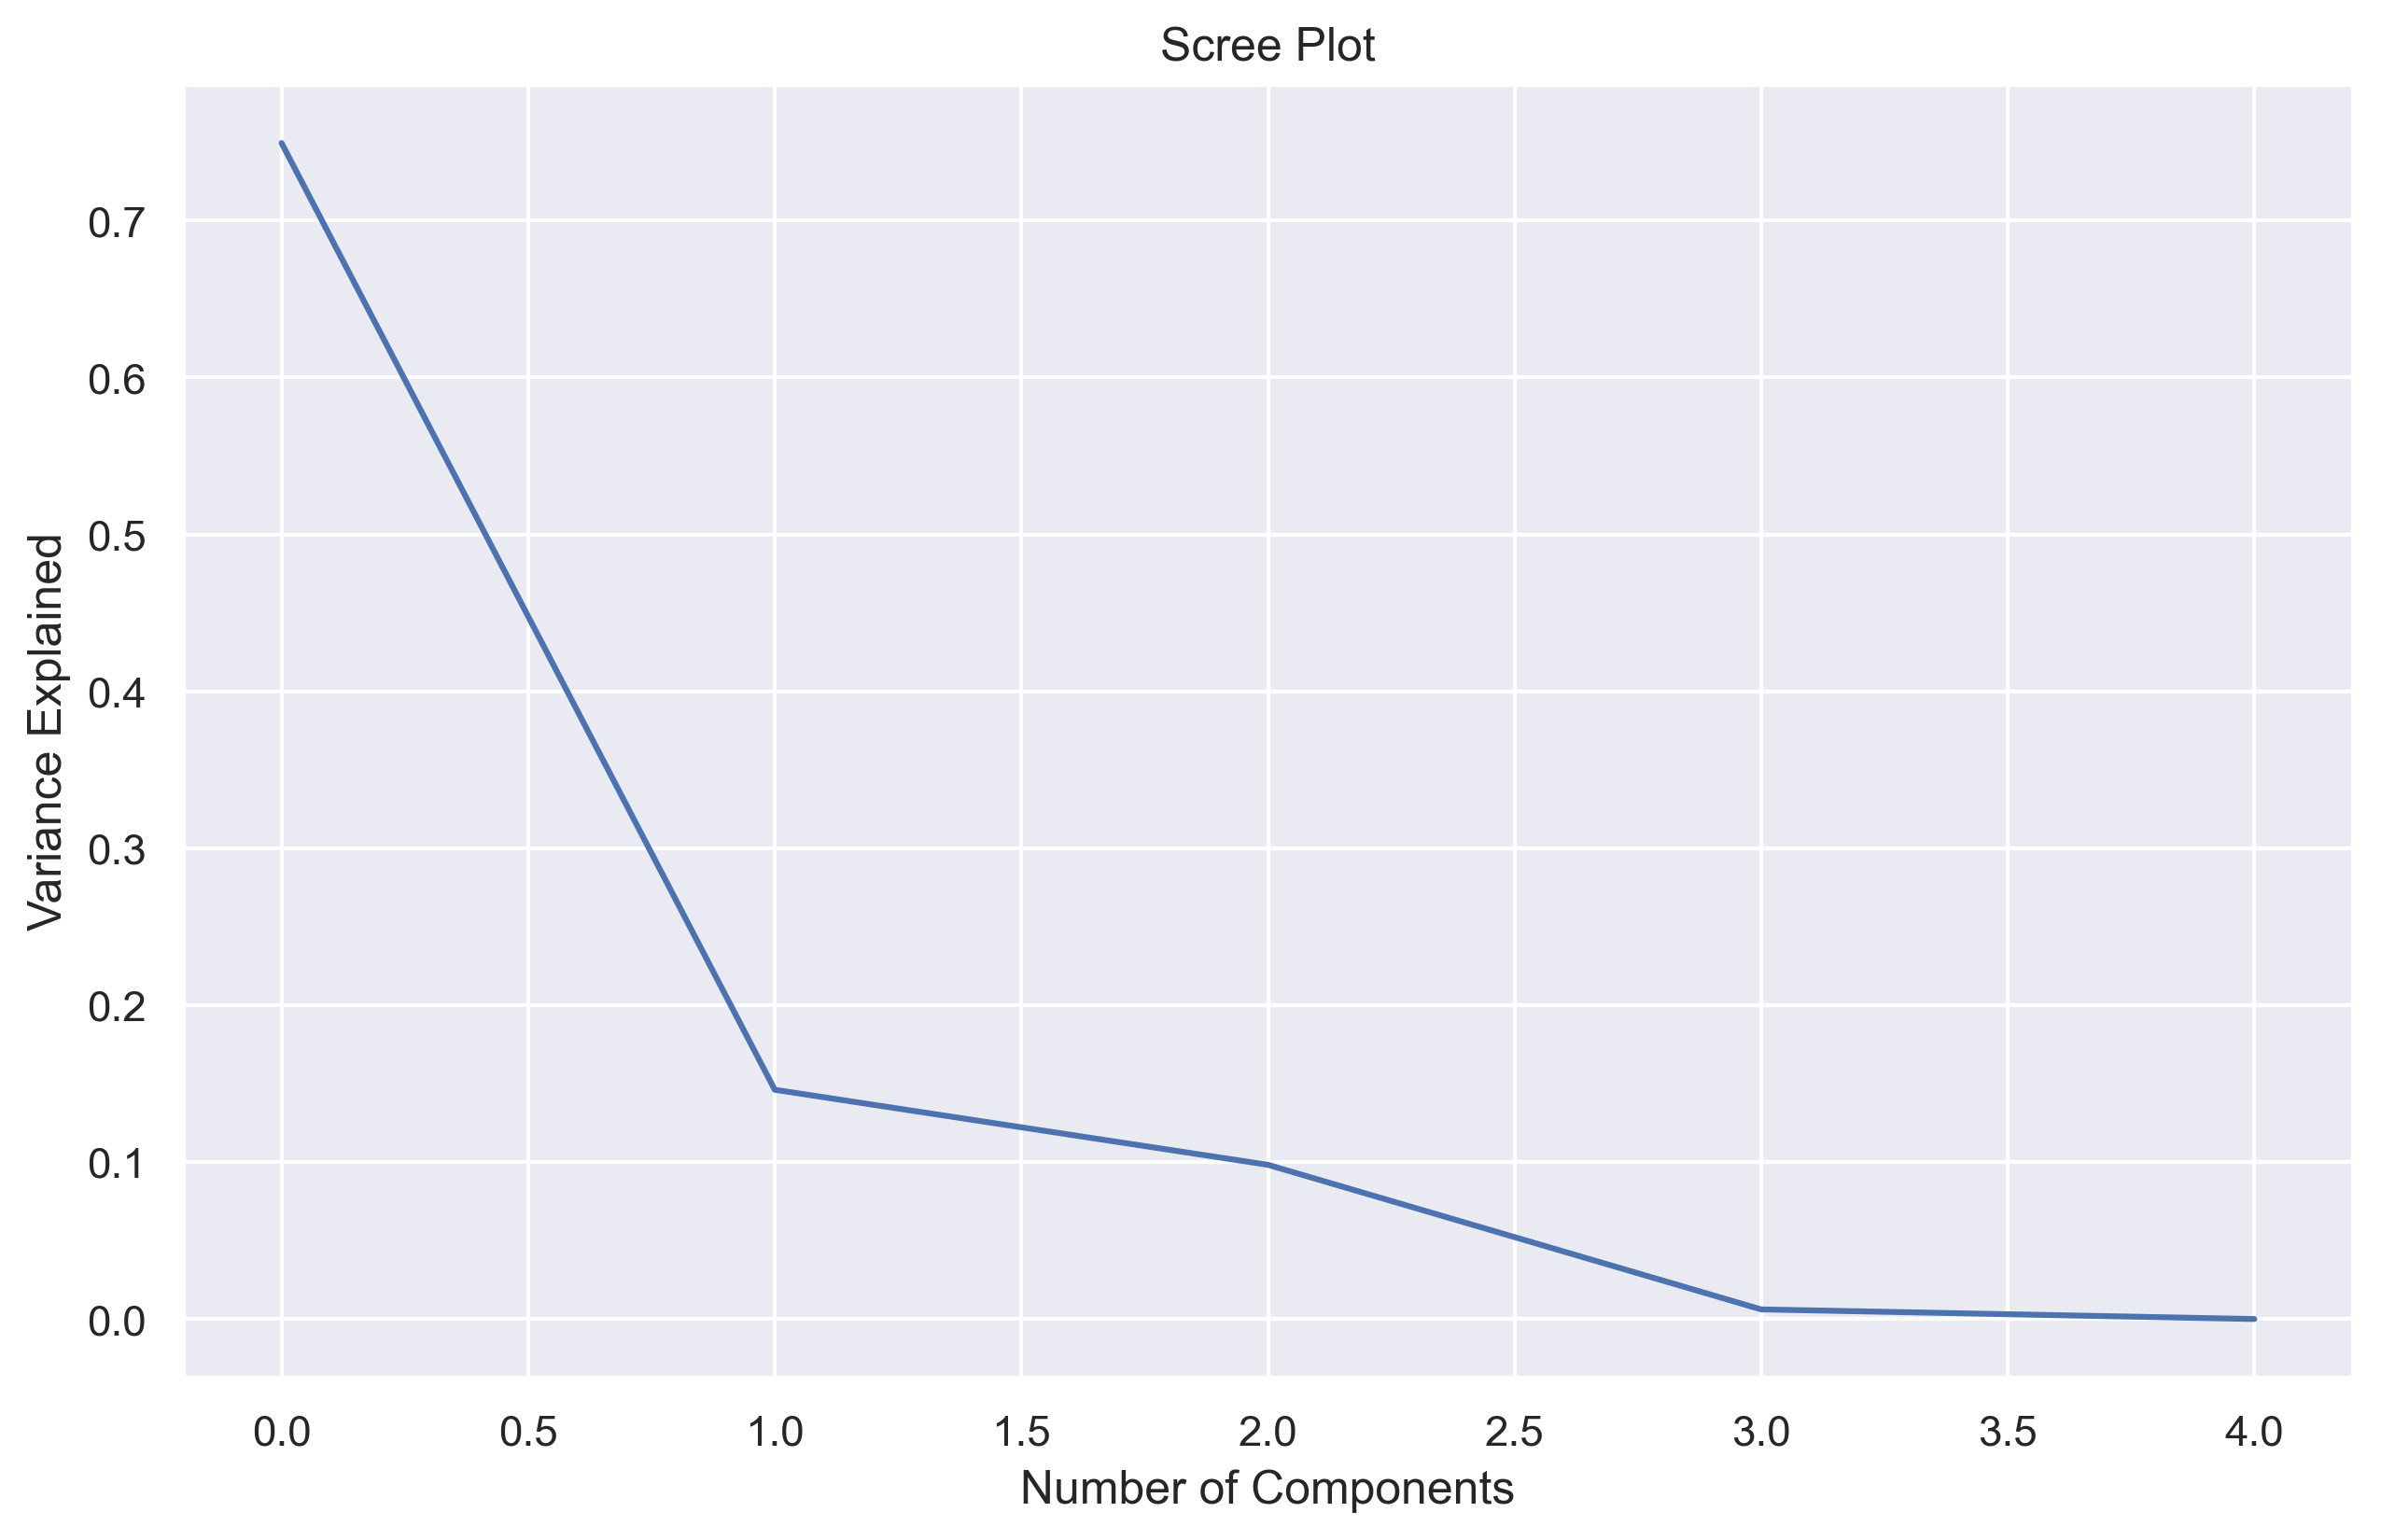

In [62]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

In [63]:
pca = PCA(n_components=2)
pca.fit(np.abs(spread_meas_scaled))
prin_comp = pca.transform(np.abs(spread_meas_scaled))
prin_comp = pd.DataFrame(np.abs(prin_comp), columns = ['Component 1',
                                                       'Component 2'])
print(pca.explained_variance_ratio_*100)  

[65.65640435 19.29704671]


In [64]:
def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex * 4, ys * scaley * 4, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r',
                  alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0], coeff[i, 1], "Var"+str(i),
                     color='black')
        else:
            plt.text(coeff[i,0 ], coeff[i, 1], labels[i],
                     color='black')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [65]:
spread_measures_scaled_df = pd.DataFrame(spread_meas_scaled,
                                         columns=spread_meas.columns)

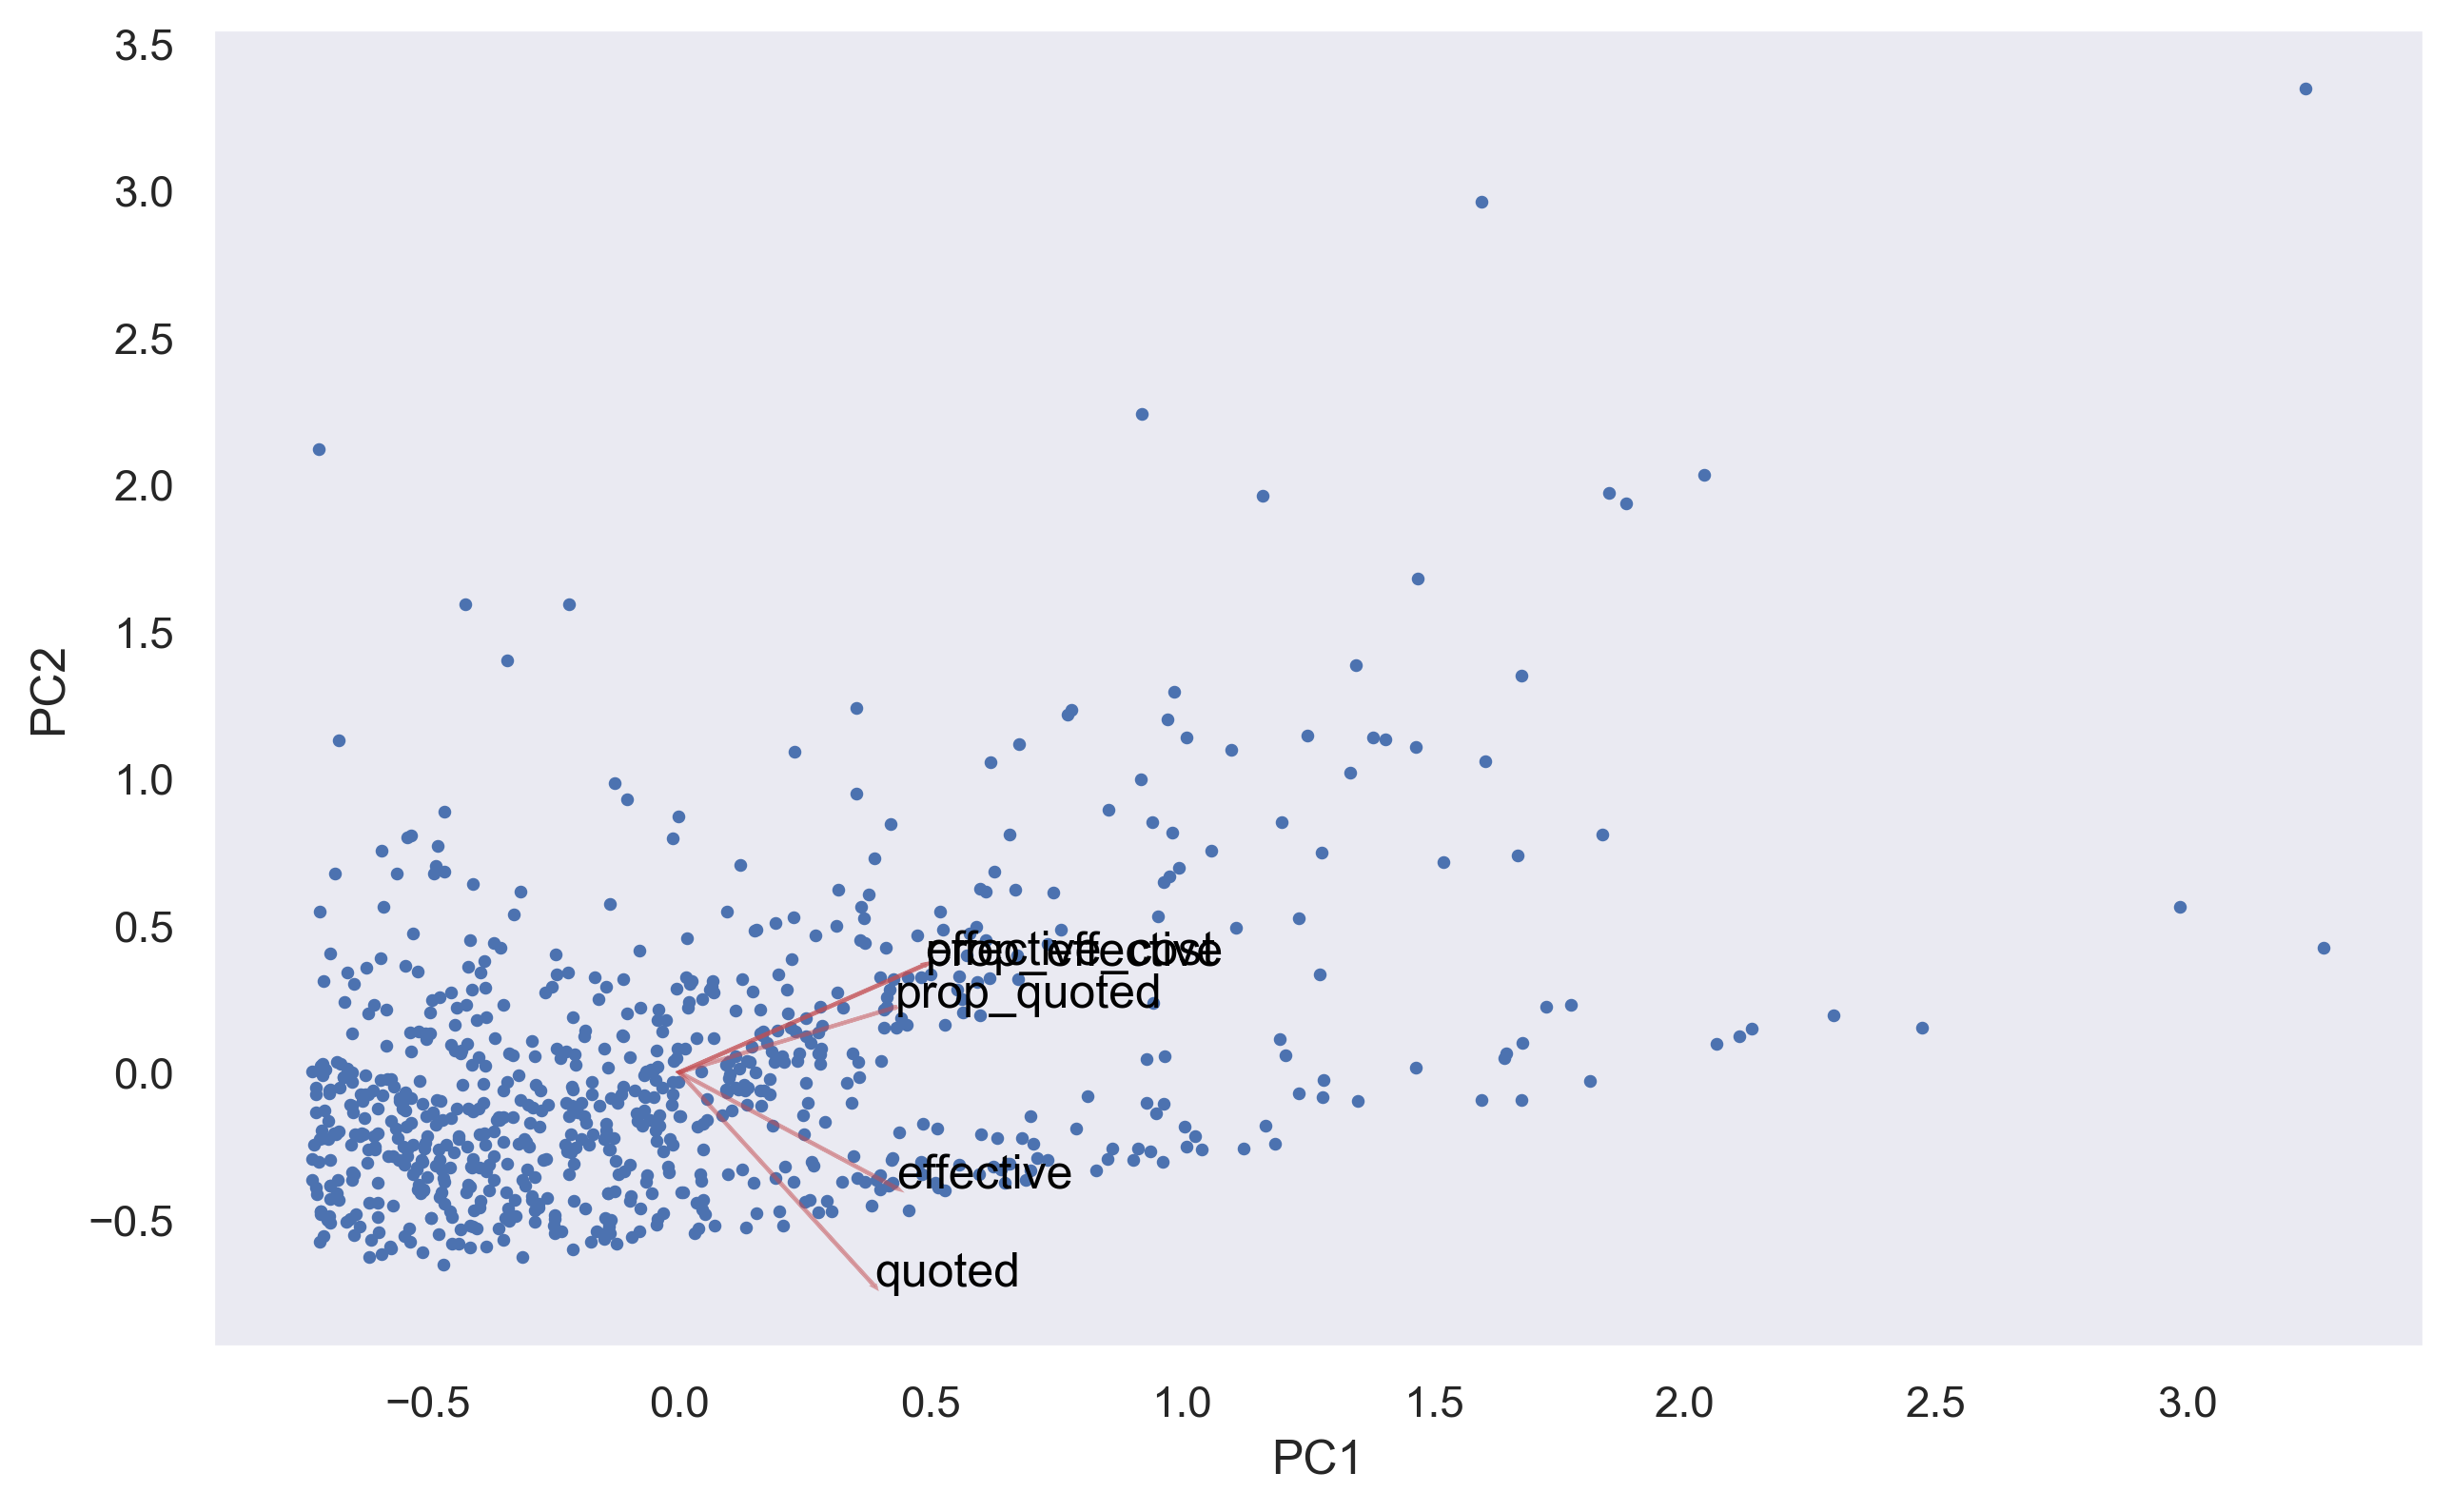

In [66]:
myplot(np.array(spread_measures_scaled_df)[:, 0:2], 
       np.transpose(pca.components_[0:2,:]), 
       list(spread_measures_scaled_df.columns))
plt.show()

현재까지 얻은 정보를 이용해 유동성 조정 ES를 계산할 수 있다. 다음은 이를 계산하는 코드이다.

In [67]:
prin_comp1_rescaled = prin_comp.iloc[:,0] * prin_comp.iloc[:,0].std()\
                      + prin_comp.iloc[:, 0].mean()
prin_comp2_rescaled = prin_comp.iloc[:,1] * prin_comp.iloc[:,1].std()\
                      + prin_comp.iloc[:, 1].mean()
prin_comp_rescaled = pd.concat([prin_comp1_rescaled, 
                                prin_comp2_rescaled],
                               axis=1)
prin_comp_rescaled.head()

,Component 1,Component 2
0,1.766661,1.256192
1,4.835170,1.939466
2,3.611486,1.551059
3,0.962666,0.601529
4,0.831065,0.734612


In [68]:
mean_pca_liq = prin_comp_rescaled.mean(axis=1).mean()
mean_pca_liq

1.0647130086973804

In [69]:
k = 1.96
for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) * 
                  (mean_pca_liq + k * std_corr)))

The liquidity Adjusted ES of IBM is 66408.9387463554
The liquidity Adjusted ES of MSFT is 62377.82867114769
The liquidity Adjusted ES of INTC is 59626.310386645695
